# 1º passo Gerar os dataset's 

• number of instances (rows in your dataset table) Bernardo  (2)

• number of classes (for multi-class classification problems) Ricardo (3)

• proportion of classes (balanced and imbalanced class problem) Ricardo (2)

• distribution of points within each class (shape of point clouds) Ricardo (3)

• shape of the border between the class regions, from linear to whatever Bernardo (3)

• level of noise André (3)

• level of overlap between the classes André (2)


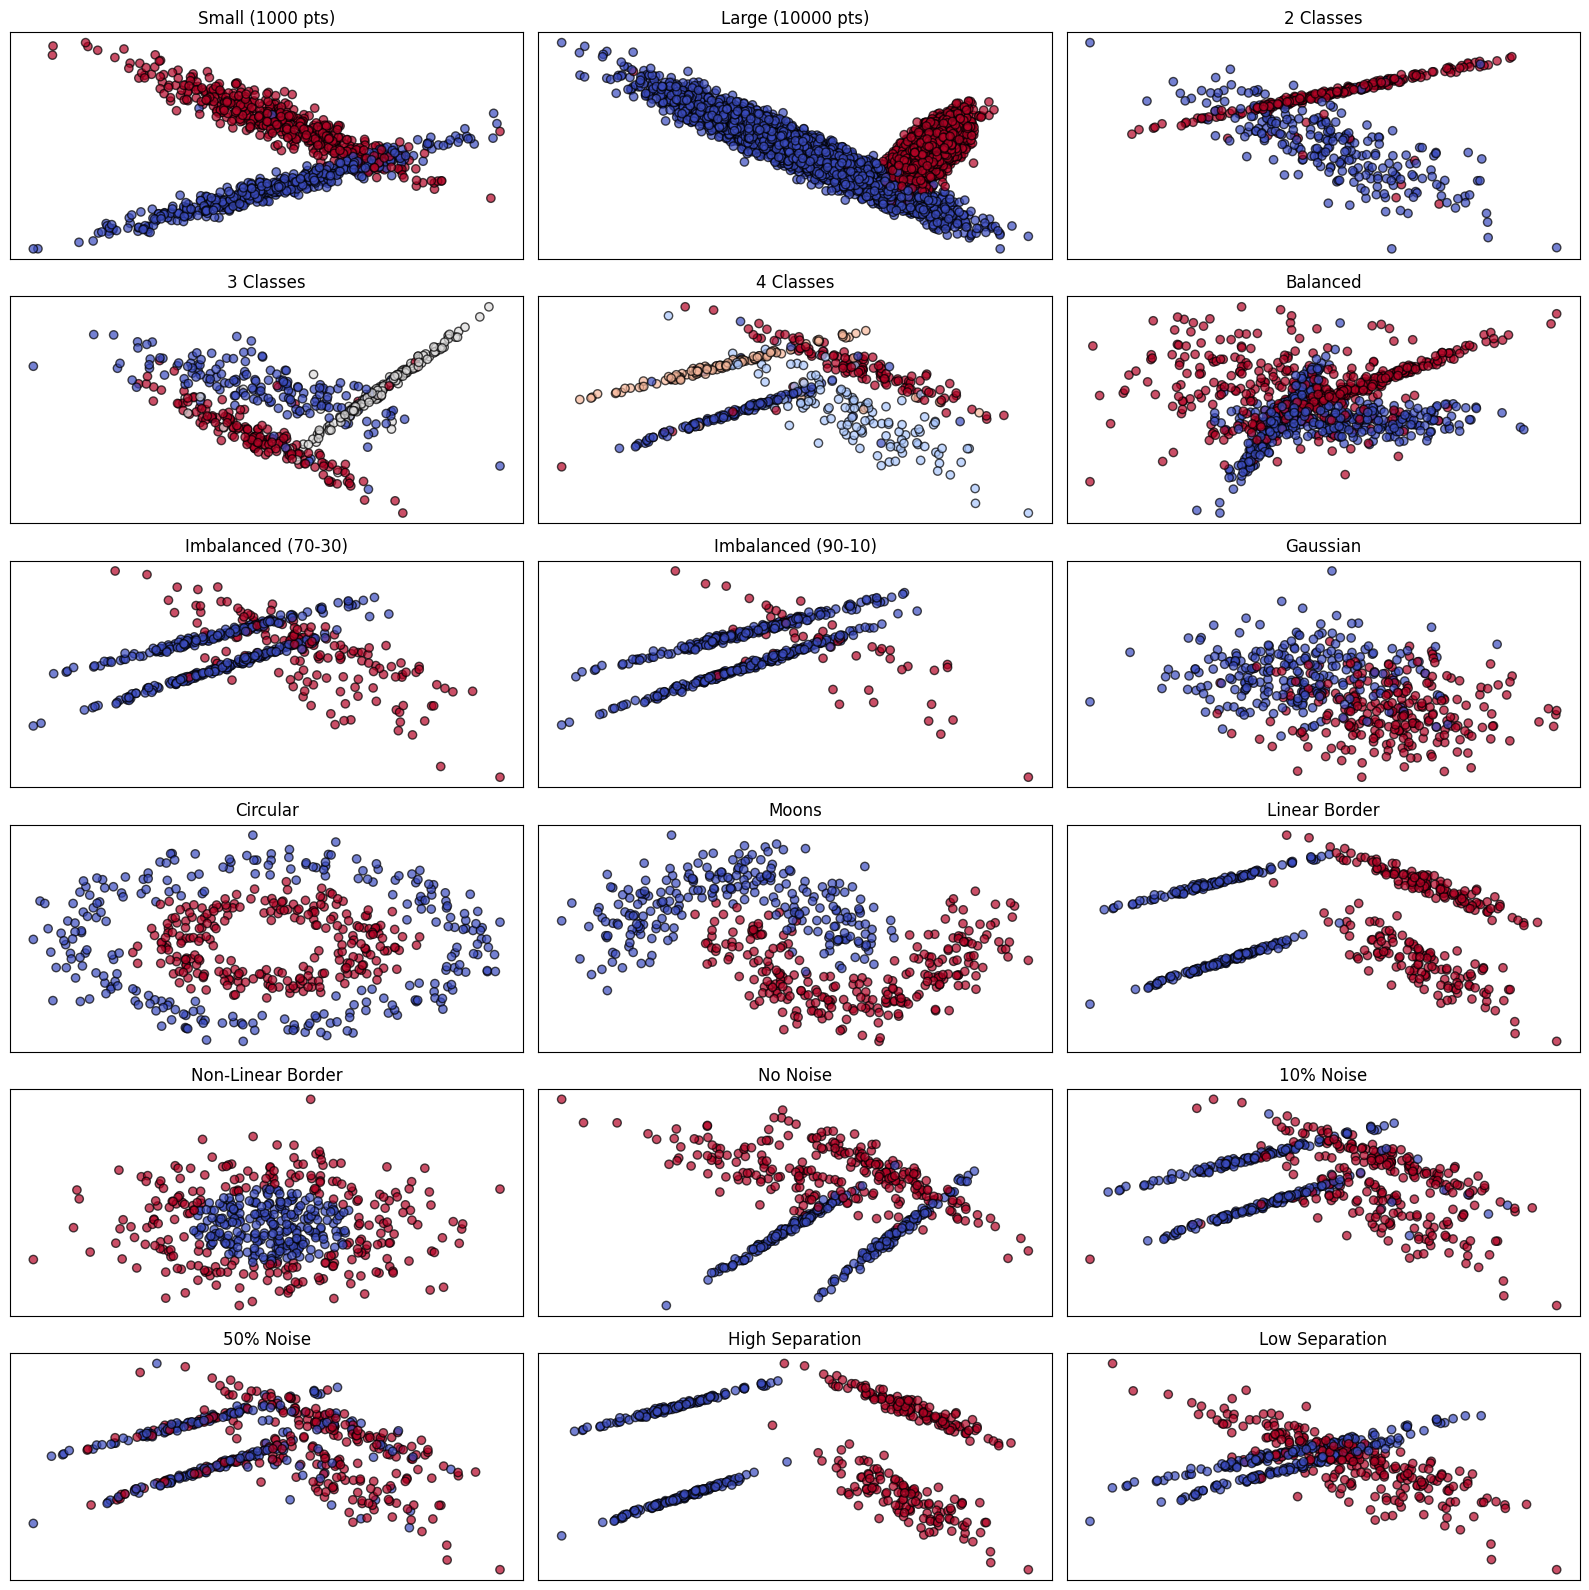

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix)
from sklearn.datasets import make_gaussian_quantiles



# Fixar seed para reprodutibilidade
np.random.seed(42)

# Lista de datasets
datasets = {}

# Número de Samples (pequeno e grande)
datasets["Small (1000 pts)"] = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
datasets["Large (10000 pts)"] = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Número de classes (2, 3 e 4)
datasets["2 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, random_state=42)
datasets["3 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, n_classes=3, random_state=42)
datasets["4 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, n_classes=4, random_state=42)

# Proporção de classes (Balanceado e Desbalanceado)
datasets["Balanced"] = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, weights=[0.5, 0.5], class_sep=0.6, random_state=42)
datasets["Imbalanced (70-30)"] = make_classification(n_samples=500, n_features=2,  n_informative=2, n_redundant=0, weights=[0.7, 0.3], class_sep=0.6, random_state=42)
datasets["Imbalanced (90-10)"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, weights=[0.9, 0.1], class_sep=0.6, random_state=42)

# Distribuição dos pontos (Gaussian, Circular, Moons)
datasets["Gaussian"] = make_blobs(n_samples=500, centers=2, cluster_std=5, random_state=42)
datasets["Circular"] = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
datasets["Moons"] = make_moons(n_samples=500, noise=0.2, random_state=42)

# Forma da fronteira (Linear vs. Não Linear)
datasets["Linear Border"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=2.0, random_state=42)
datasets["Non-Linear Border"] = make_gaussian_quantiles(mean=[0, 0],cov=3.0,n_samples=500,n_features=2,n_classes=2,random_state=42)

# Nível de Ruído (0, 10%, 30%)
datasets["No Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.0, random_state=42)
datasets["10% Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.1, random_state=42)
datasets["50% Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.5, random_state=42)

# Sobreposição entre classes (Separação alta vs. baixa)
datasets["High Separation"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=2.5, random_state=42)
datasets["Low Separation"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=0.3, random_state=42)

# 📊 Visualizar os datasets
fig, axes = plt.subplots(6, 3, figsize=(16, 16))
for ax, (name, (X, y)) in zip(axes.flatten(), datasets.items()):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor='k', alpha=0.7)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Separar datasets em treino e teste
datasets_train_test = {name: train_test_split(X, y, test_size=0.3, random_state=42) for name, (X, y) in datasets.items()}


 

Análise dos modelos nos datasets

In [79]:
import time

# Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Decision Tree (depth=2)": DecisionTreeClassifier(max_depth=2),
    "Logistic Regression": LogisticRegression(),
    "LDA": LDA(),
    "QDA": QDA(),
    "SVM (linear)": SVC(kernel='linear', probability=True),
    "SVM (rbf)": SVC(kernel='rbf', probability=True)
}

# Function to plot decision boundaries for all models
def plot_decision_boundaries(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    for ax, (name, model) in zip(axes, models.items()):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolor='k', alpha=0.7)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f"Decision Boundaries - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Function to plot all ROC curves in the same figure (skip multiclass)
def plot_roc_curves(models, X_test, y_test, dataset_name):
    if len(np.unique(y_test)) > 2:  # Check if dataset is multiclass
        print(f"⚠️ Skipping ROC Curve (Multiclass detected) for {dataset_name}")
        return
    
    plt.figure(figsize=(6, 6))
    
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")
              
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {dataset_name}")
    plt.legend(loc="lower right")
    plt.show()

# Function to plot all confusion matrices in the same figure
def plot_confusion_matrices(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    
    for ax, (name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax)
        ax.set_title(name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.suptitle(f"Confusion Matrices - {dataset_name}")
    plt.tight_layout()
    plt.show()


def evaluate_dataset(dataset_name, cv_folds=5):
    if dataset_name not in datasets_train_test:
        print(f"❌ Dataset '{dataset_name}' not found!")
        return
    X_train, X_test, y_train, y_test = datasets_train_test[dataset_name]
    print(f"\n📊 Evaluating Dataset: {dataset_name} (Cross-Validation: {cv_folds}-fold)")

    trained_models = {}
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Train and evaluate all classifiers
    for name, model in classifiers.items():
        start_time = time.time()
        # Cross-validation scores
        acc_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        prec_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision_weighted', error_score='raise')
        rec_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall_weighted', error_score='raise')
        f1_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_weighted', error_score='raise')

        print(f"🔹 {name}:")
        print(f"   ↪️ CV Accuracy: {acc_scores.mean():.2f} ± {acc_scores.std():.2f}")
        print(f"   ↪️ CV Precision: {prec_scores.mean():.2f} ± {prec_scores.std():.2f}")
        print(f"   ↪️ CV Recall: {rec_scores.mean():.2f} ± {rec_scores.std():.2f}")
        print(f"   ↪️ CV F1-score: {f1_scores.mean():.2f} ± {f1_scores.std():.2f}")

        # Train final model on full training set
        model.fit(X_train, y_train)
        trained_models[name] = model
        end_time = time.time()
        print(f"Processing time was {round(end_time-start_time,2)} segundos")

    # Generate plots with trained models
    plot_decision_boundaries(trained_models, X_test, y_test, dataset_name)
    plot_roc_curves(trained_models, X_test, y_test, dataset_name)
    plot_confusion_matrices(trained_models, X_test, y_test, dataset_name)
   



Small (200pts) Vs Large (10000pts)
    


📊 Evaluating Dataset: Small (1000 pts) (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.93 ± 0.01
   ↪️ CV Precision: 0.93 ± 0.01
   ↪️ CV Recall: 0.93 ± 0.01
   ↪️ CV F1-score: 0.92 ± 0.01
Processing time was 0.13 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.93 ± 0.02
   ↪️ CV Precision: 0.93 ± 0.02
   ↪️ CV Recall: 0.93 ± 0.02
   ↪️ CV F1-score: 0.93 ± 0.02
Processing time was 0.08 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.92 ± 0.02
   ↪️ CV Precision: 0.92 ± 0.01
   ↪️ CV Recall: 0.92 ± 0.02
   ↪️ CV F1-score: 0.92 ± 0.02
Processing time was 0.2 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.91 ± 0.01
   ↪️ CV Precision: 0.91 ± 0.01
   ↪️ CV Recall: 0.91 ± 0.01
   ↪️ CV F1-score: 0.91 ± 0.02
Processing time was 0.07 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.96 ± 0.02
   ↪️ CV Precision: 0.96 ± 0.01
   ↪️ CV Recall: 0.96 ± 0.02
   ↪️ CV F1-score: 0.96 ± 0.02
Processing time was 0.05 segundos
🔹 SVM (linear):
   ↪️ CV Accuracy: 0.93 ± 0.02
   ↪️ CV Precision: 0

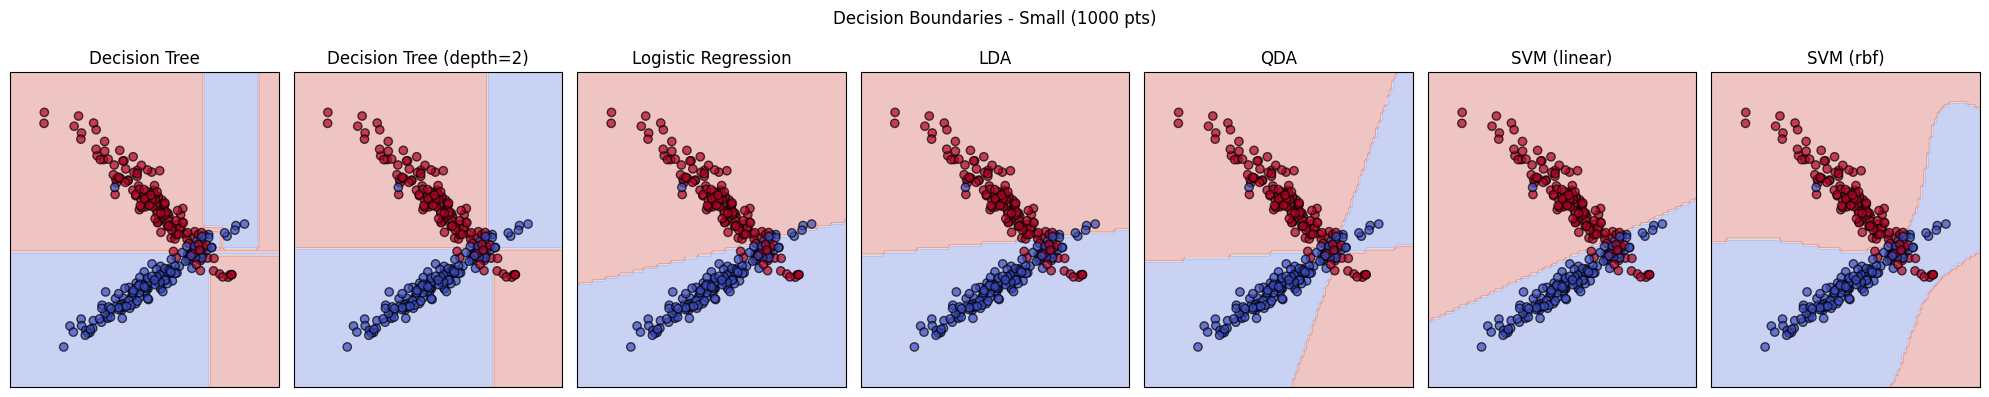

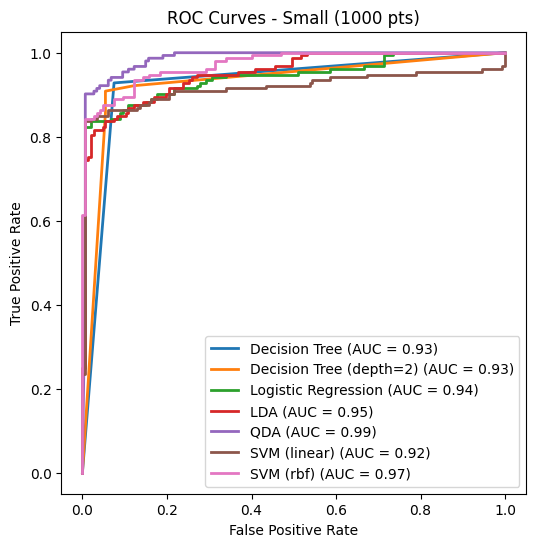

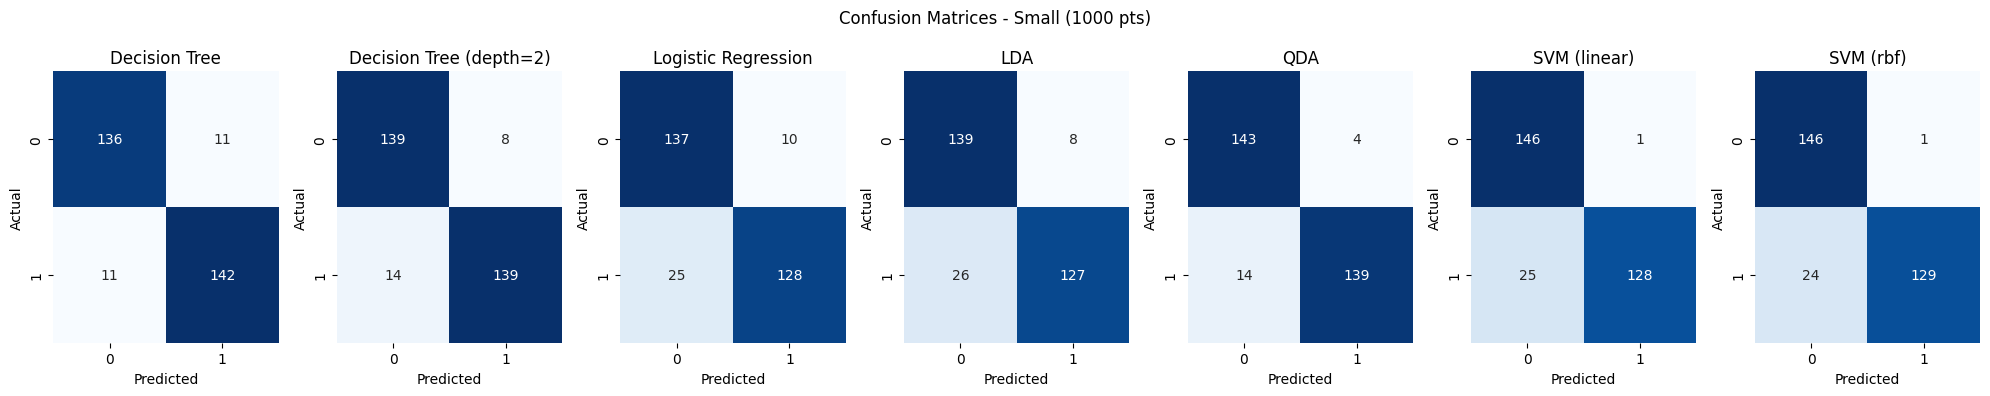


📊 Evaluating Dataset: Large (10000 pts) (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.97 ± 0.00
   ↪️ CV Precision: 0.97 ± 0.00
   ↪️ CV Recall: 0.97 ± 0.00
   ↪️ CV F1-score: 0.97 ± 0.00
Processing time was 0.71 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.98 ± 0.00
   ↪️ CV Precision: 0.98 ± 0.00
   ↪️ CV Recall: 0.98 ± 0.00
   ↪️ CV F1-score: 0.98 ± 0.00
Processing time was 0.26 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.98 ± 0.00
   ↪️ CV Precision: 0.98 ± 0.00
   ↪️ CV Recall: 0.98 ± 0.00
   ↪️ CV F1-score: 0.98 ± 0.00
Processing time was 0.3 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.97 ± 0.01
   ↪️ CV Precision: 0.97 ± 0.01
   ↪️ CV Recall: 0.97 ± 0.01
   ↪️ CV F1-score: 0.97 ± 0.01
Processing time was 0.17 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.98 ± 0.00
   ↪️ CV Precision: 0.98 ± 0.00
   ↪️ CV Recall: 0.98 ± 0.00
   ↪️ CV F1-score: 0.98 ± 0.00
Processing time was 0.11 segundos
🔹 SVM (linear):
   ↪️ CV Accuracy: 0.98 ± 0.00
   ↪️ CV Precision: 

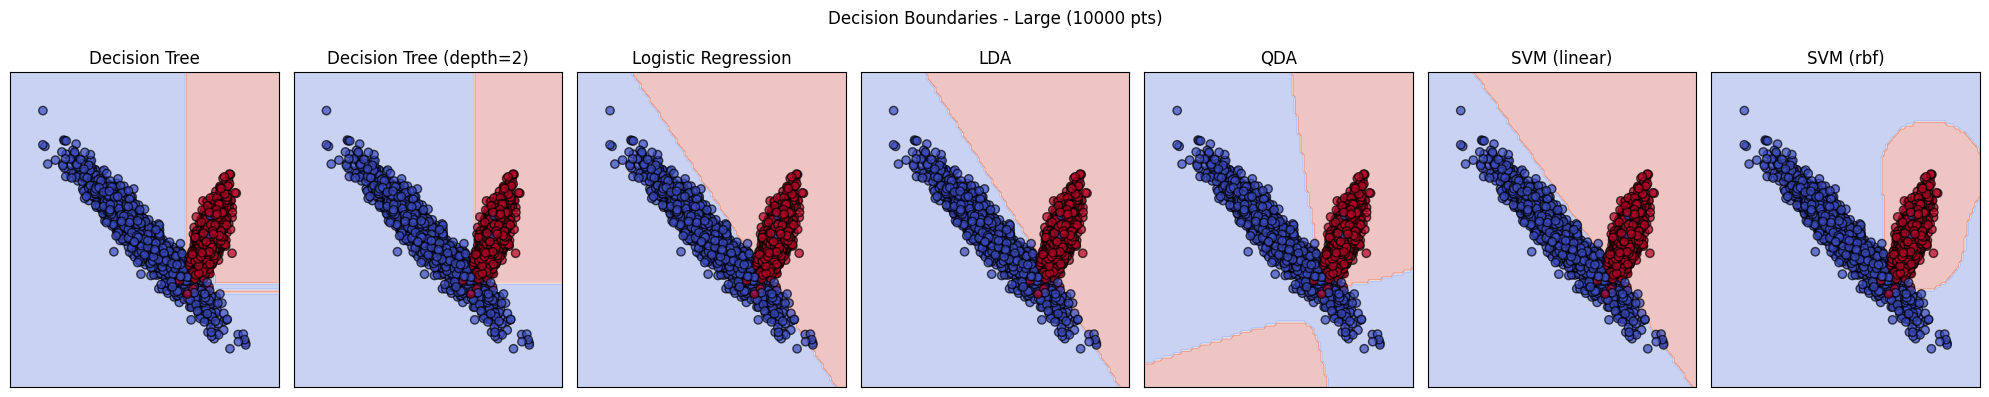

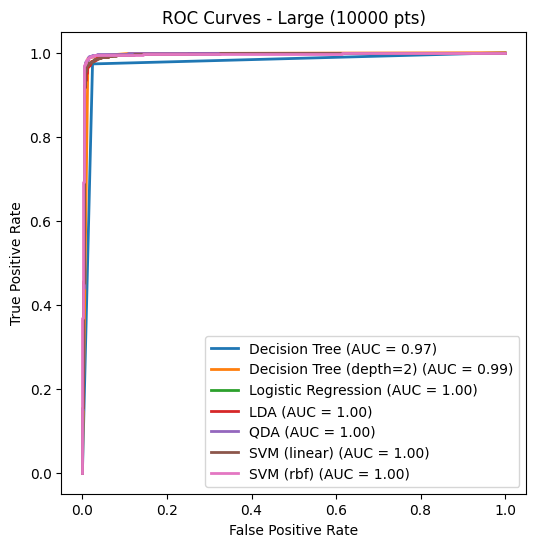

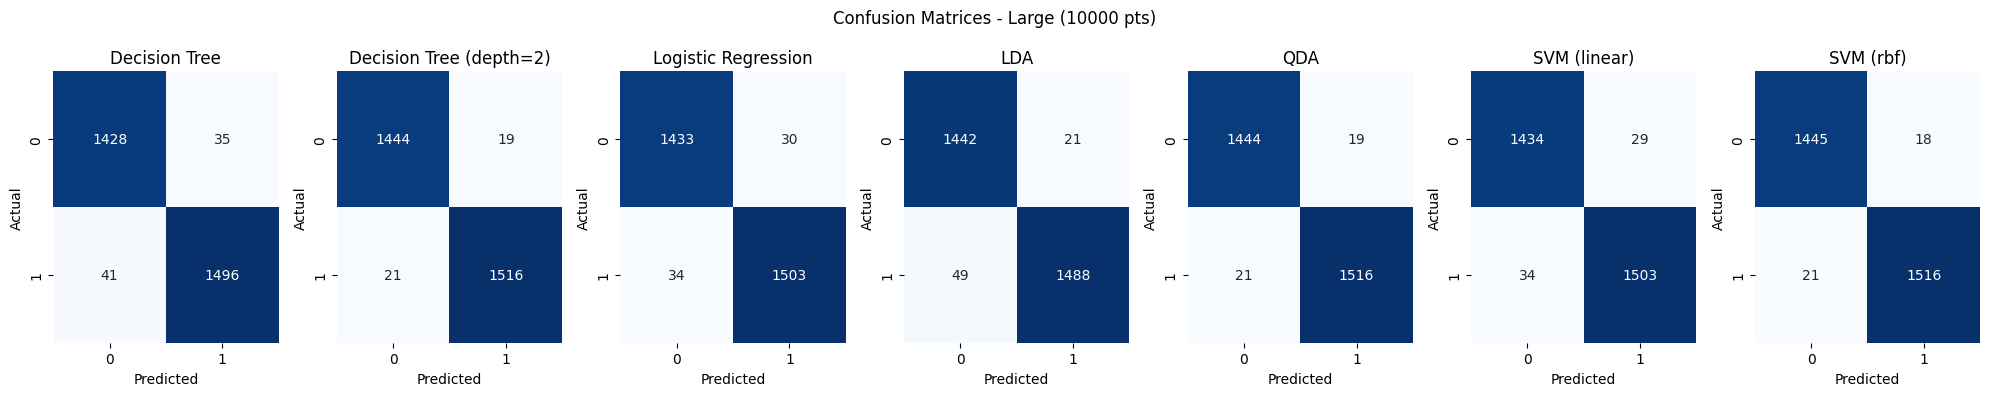

In [89]:
evaluate_dataset("Small (1000 pts)", cv_folds=5)
evaluate_dataset("Large (10000 pts)", cv_folds=5)



Conclusões Principais:
- Todos os modelos melhoraram com o aumento do número de pontos pois tiveram mais exemplos onde treinar
- Inicialemente o algoritmo QDA foi o modelo mais rápido a avaliar o dataset (também o mais preciso) Com o aumentar da dimensão do dataset os algoritmos decisions trees, logistic regression aumentaram ligeiramente o seu tempo de processamento, o QDA e LDA tiveram o menor aumento já o SVM linear e rbf tiveram aumentos na ordem das 100x mostrando alguma dificuldade em lidar com datasets de maiores dimensões
- É importante notar que uma vez que a função make classification dispersa os seus valores seguindo uma distribuição estatistica pseudo-aleatório, entre ambos os datasets analisados não variou apenas o número de amostras mas também ligeiramente o tipo de dispersão obtida o que pode afetar ligeiramente as conclusões retiradas anteriormente


📊 Evaluating Dataset: Low Separation (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.86 ± 0.04
   ↪️ CV Precision: 0.86 ± 0.03
   ↪️ CV Recall: 0.86 ± 0.02
   ↪️ CV F1-score: 0.86 ± 0.03
Processing time was 0.1699998378753662 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.86 ± 0.03
   ↪️ CV Precision: 0.89 ± 0.02
   ↪️ CV Recall: 0.86 ± 0.03
   ↪️ CV F1-score: 0.86 ± 0.03
Processing time was 0.1400001049041748 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.67 ± 0.04
   ↪️ CV Precision: 0.68 ± 0.04
   ↪️ CV Recall: 0.67 ± 0.04
   ↪️ CV F1-score: 0.67 ± 0.04
Processing time was 0.1700000762939453 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.68 ± 0.04
   ↪️ CV Precision: 0.69 ± 0.03
   ↪️ CV Recall: 0.68 ± 0.04
   ↪️ CV F1-score: 0.68 ± 0.04
Processing time was 0.1399998664855957 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.90 ± 0.04
   ↪️ CV Precision: 0.91 ± 0.02
   ↪️ CV Recall: 0.90 ± 0.04
   ↪️ CV F1-score: 0.90 ± 0.04
Processing time was 0.1100001335144043 segundos

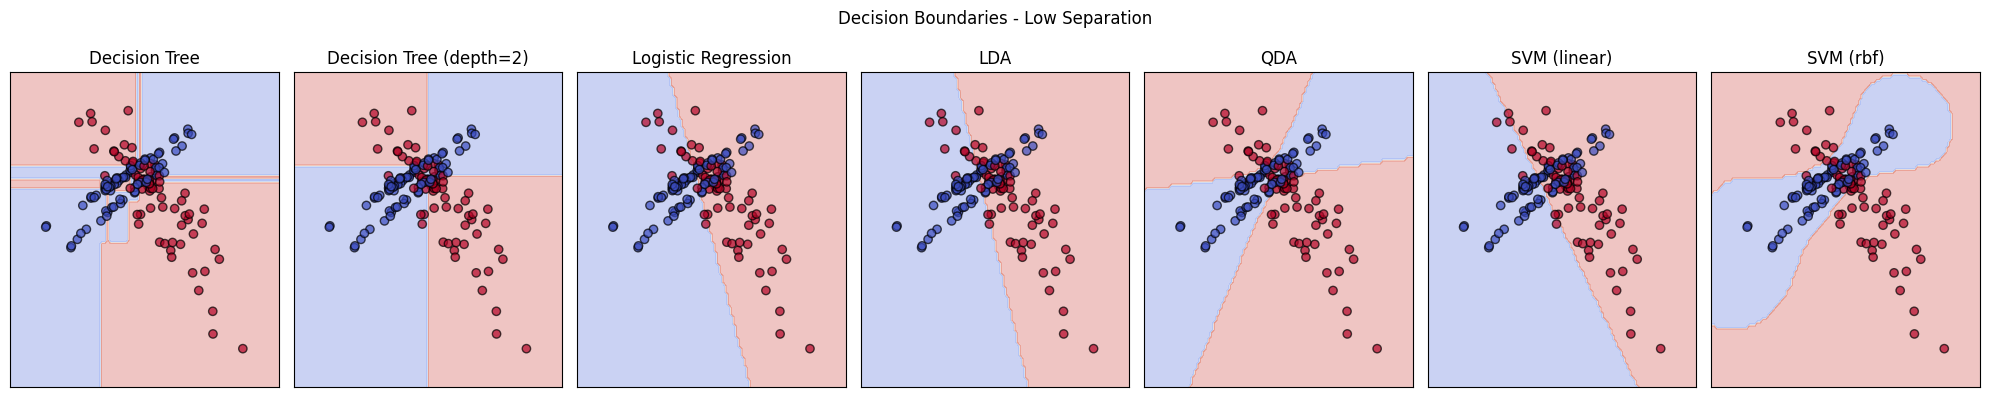

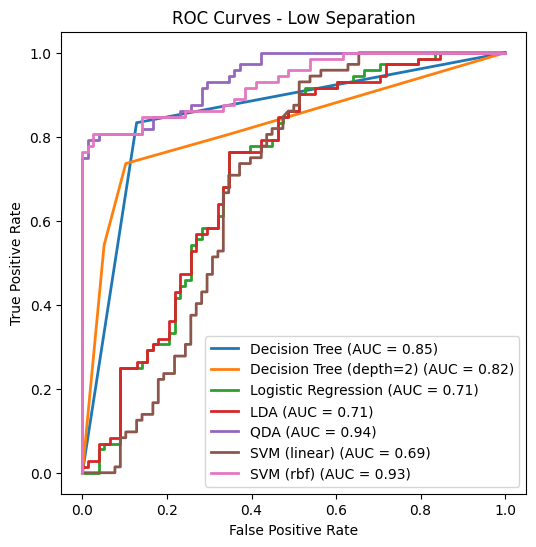

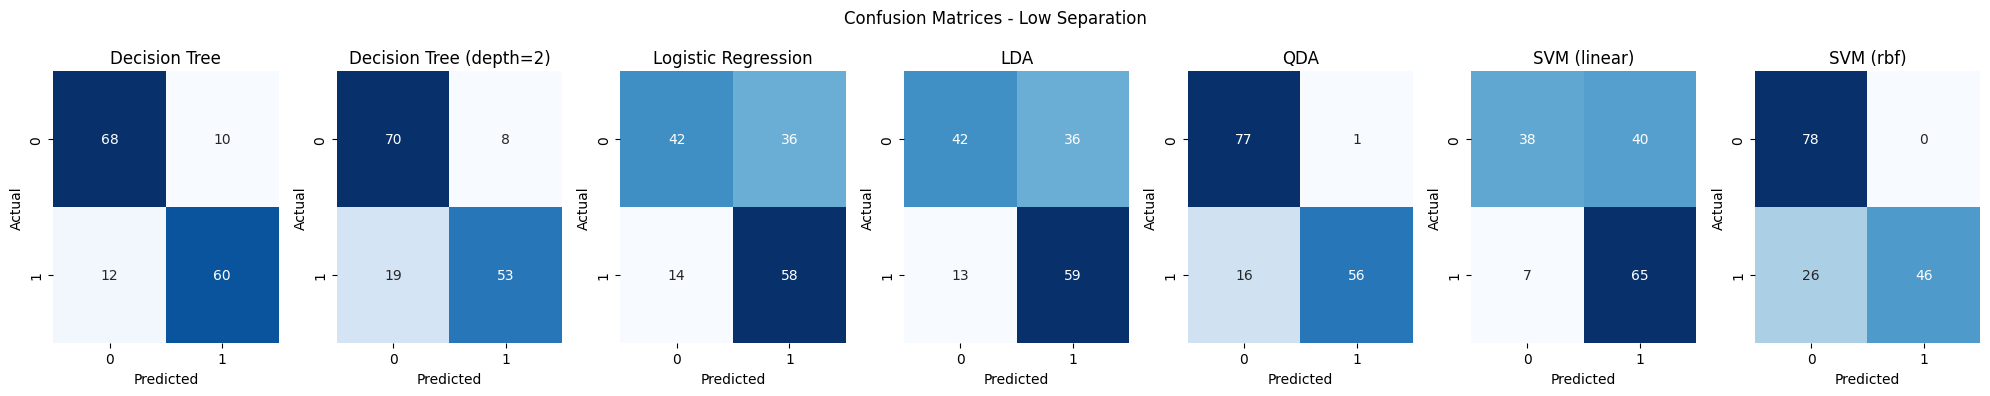

In [ ]:

evaluate_dataset("Low Separation")   

# Number of Classes 


📊 Evaluating Dataset: 2 Classes (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.85 ± 0.03
   ↪️ CV Precision: 0.85 ± 0.03
   ↪️ CV Recall: 0.85 ± 0.03
   ↪️ CV F1-score: 0.85 ± 0.04
Processing time was 0.15000009536743164 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.87 ± 0.04
   ↪️ CV Precision: 0.88 ± 0.04
   ↪️ CV Recall: 0.87 ± 0.04
   ↪️ CV F1-score: 0.87 ± 0.04
Processing time was 0.11999988555908203 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.84 ± 0.03
   ↪️ CV Precision: 0.85 ± 0.03
   ↪️ CV Recall: 0.84 ± 0.03
   ↪️ CV F1-score: 0.84 ± 0.04
Processing time was 0.20000004768371582 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.83 ± 0.04
   ↪️ CV Precision: 0.84 ± 0.03
   ↪️ CV Recall: 0.83 ± 0.04
   ↪️ CV F1-score: 0.83 ± 0.04
Processing time was 0.1399998664855957 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.86 ± 0.06
   ↪️ CV Precision: 0.88 ± 0.05
   ↪️ CV Recall: 0.86 ± 0.06
   ↪️ CV F1-score: 0.86 ± 0.06
Processing time was 0.12000012397766113 segundos


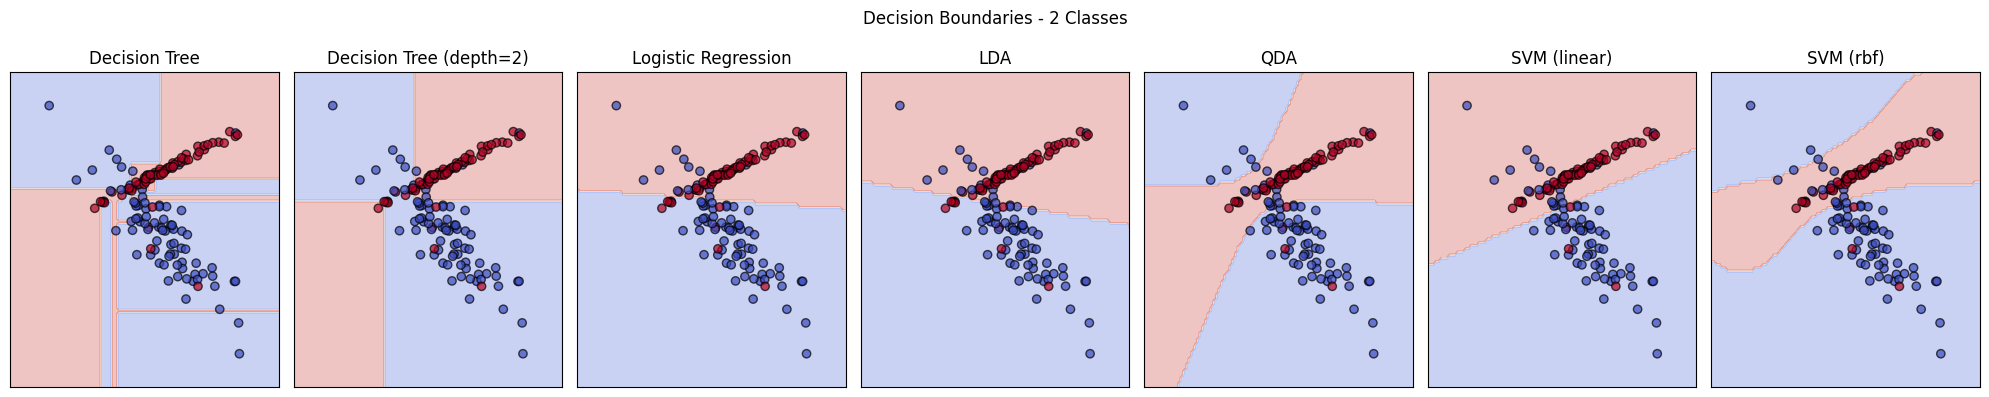

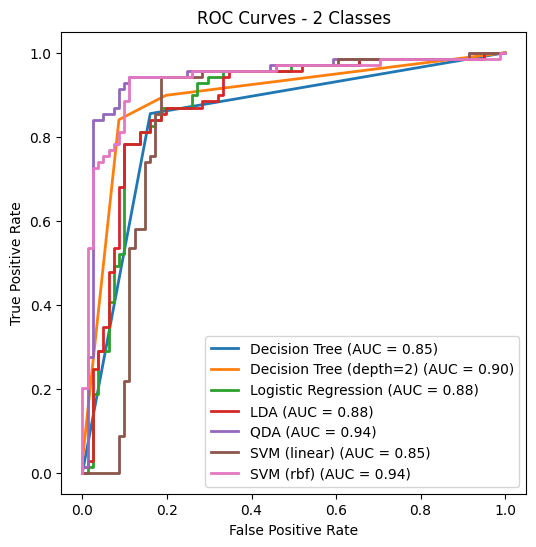

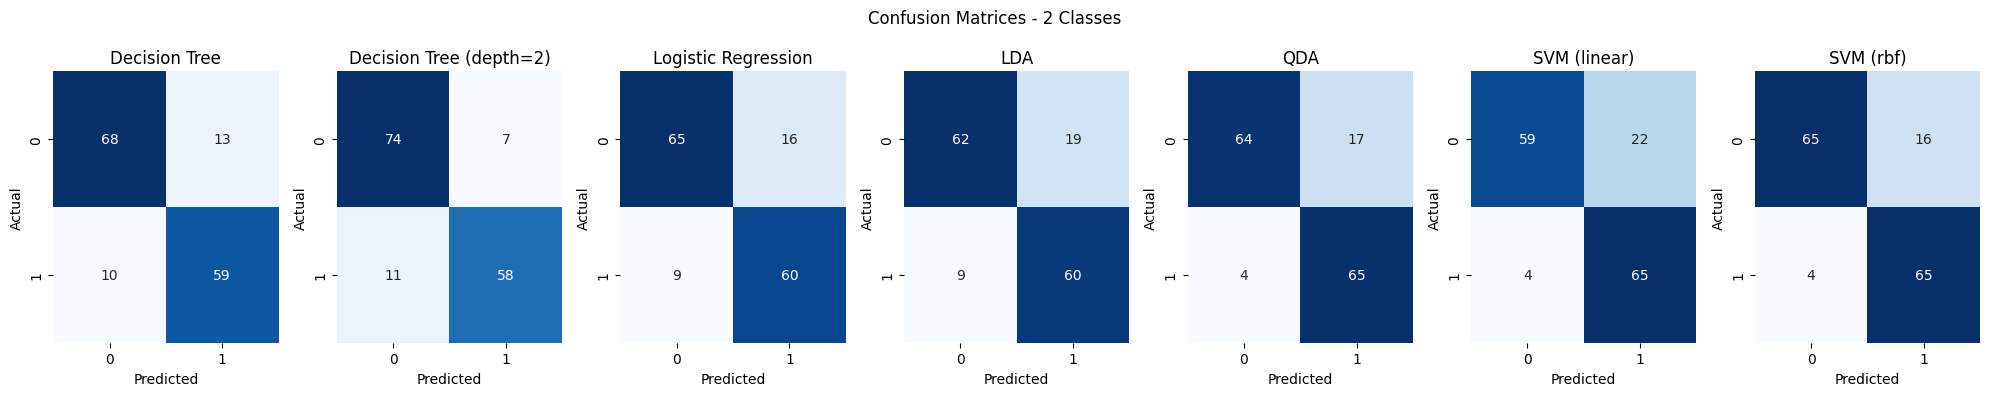

In [ ]:
evaluate_dataset("2 Classes")   


📊 Evaluating Dataset: 3 Classes (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.80 ± 0.05
   ↪️ CV Precision: 0.80 ± 0.04
   ↪️ CV Recall: 0.79 ± 0.04
   ↪️ CV F1-score: 0.78 ± 0.05
Processing time was 0.15999984741210938 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.77 ± 0.07
   ↪️ CV Precision: 0.78 ± 0.07
   ↪️ CV Recall: 0.77 ± 0.07
   ↪️ CV F1-score: 0.77 ± 0.07
Processing time was 0.13000011444091797 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.84 ± 0.05
   ↪️ CV Precision: 0.85 ± 0.04
   ↪️ CV Recall: 0.84 ± 0.05
   ↪️ CV F1-score: 0.84 ± 0.05
Processing time was 0.25 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.80 ± 0.06
   ↪️ CV Precision: 0.81 ± 0.05
   ↪️ CV Recall: 0.80 ± 0.06
   ↪️ CV F1-score: 0.80 ± 0.06
Processing time was 0.1399998664855957 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.84 ± 0.06
   ↪️ CV Precision: 0.85 ± 0.05
   ↪️ CV Recall: 0.84 ± 0.06
   ↪️ CV F1-score: 0.84 ± 0.06
Processing time was 0.1100001335144043 segundos
🔹 SVM (linear):


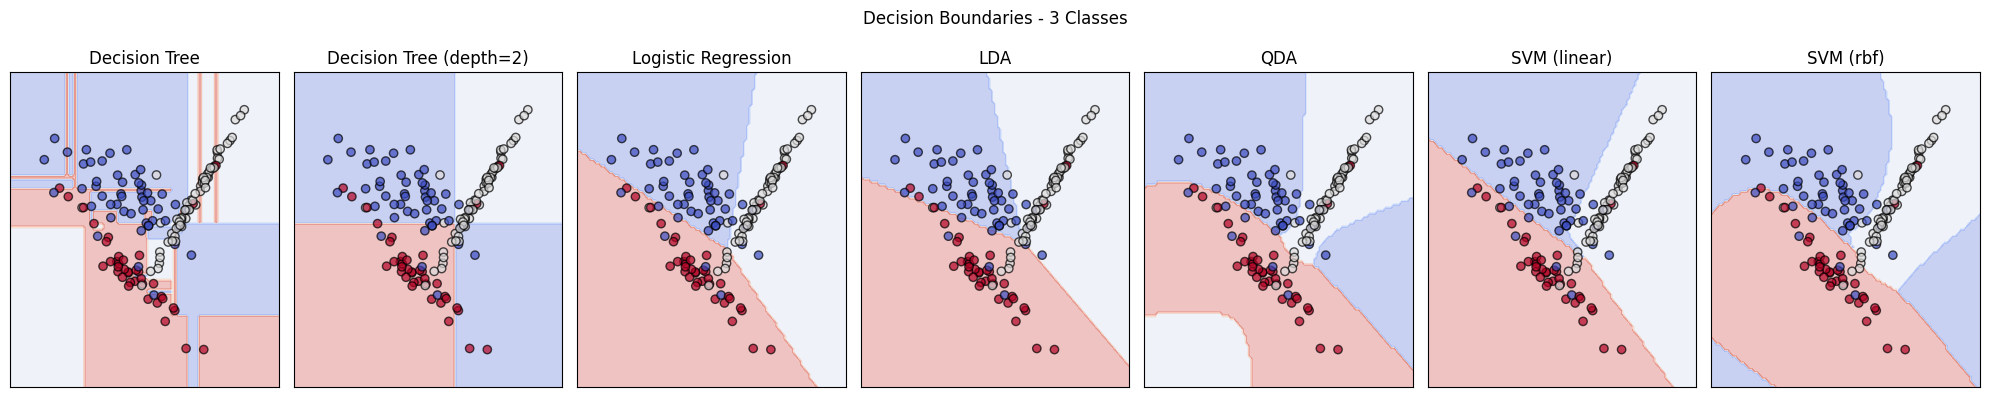

⚠️ Skipping ROC Curve (Multiclass detected) for 3 Classes


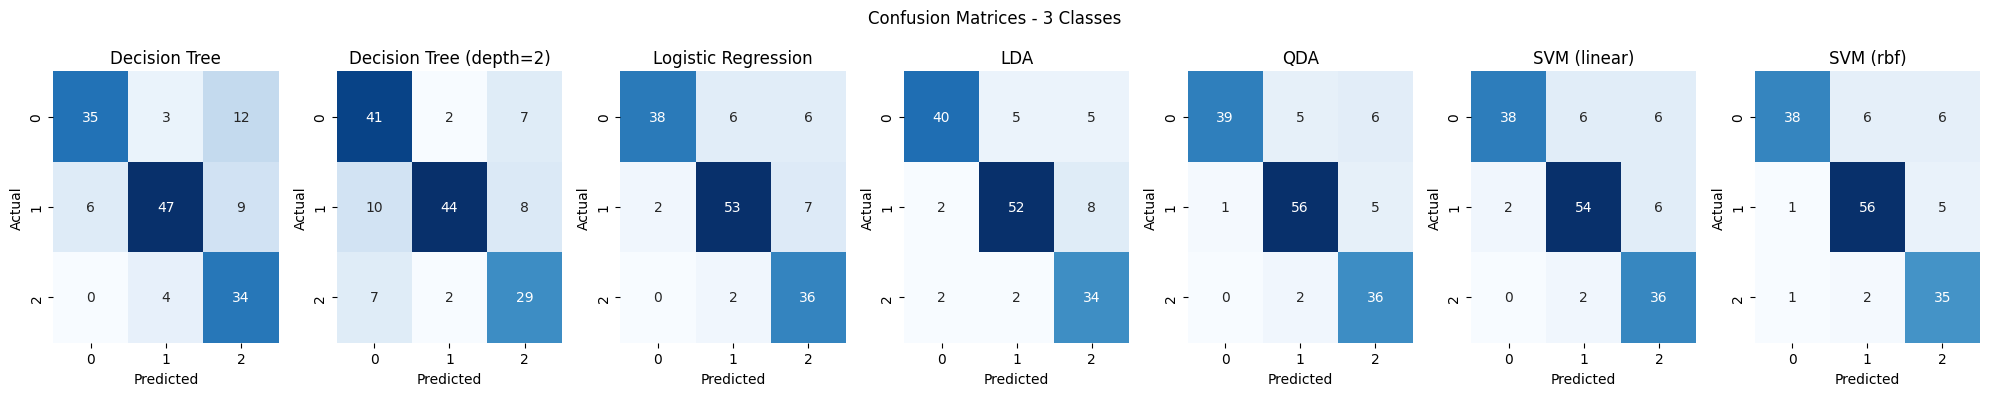

In [ ]:
evaluate_dataset("3 Classes")   



📊 Evaluating Dataset: 4 Classes (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.74 ± 0.04
   ↪️ CV Precision: 0.76 ± 0.05
   ↪️ CV Recall: 0.74 ± 0.05
   ↪️ CV F1-score: 0.73 ± 0.04
Processing time was 0.15000009536743164 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.76 ± 0.03
   ↪️ CV Precision: 0.77 ± 0.04
   ↪️ CV Recall: 0.76 ± 0.03
   ↪️ CV F1-score: 0.76 ± 0.03
Processing time was 0.1399998664855957 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.78 ± 0.05
   ↪️ CV Precision: 0.79 ± 0.05
   ↪️ CV Recall: 0.78 ± 0.05
   ↪️ CV F1-score: 0.78 ± 0.05
Processing time was 0.3000001907348633 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.76 ± 0.05
   ↪️ CV Precision: 0.77 ± 0.04
   ↪️ CV Recall: 0.76 ± 0.05
   ↪️ CV F1-score: 0.76 ± 0.04
Processing time was 0.12999987602233887 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.80 ± 0.06
   ↪️ CV Precision: 0.82 ± 0.07
   ↪️ CV Recall: 0.80 ± 0.06
   ↪️ CV F1-score: 0.80 ± 0.06
Processing time was 0.15000009536743164 segundos
🔹

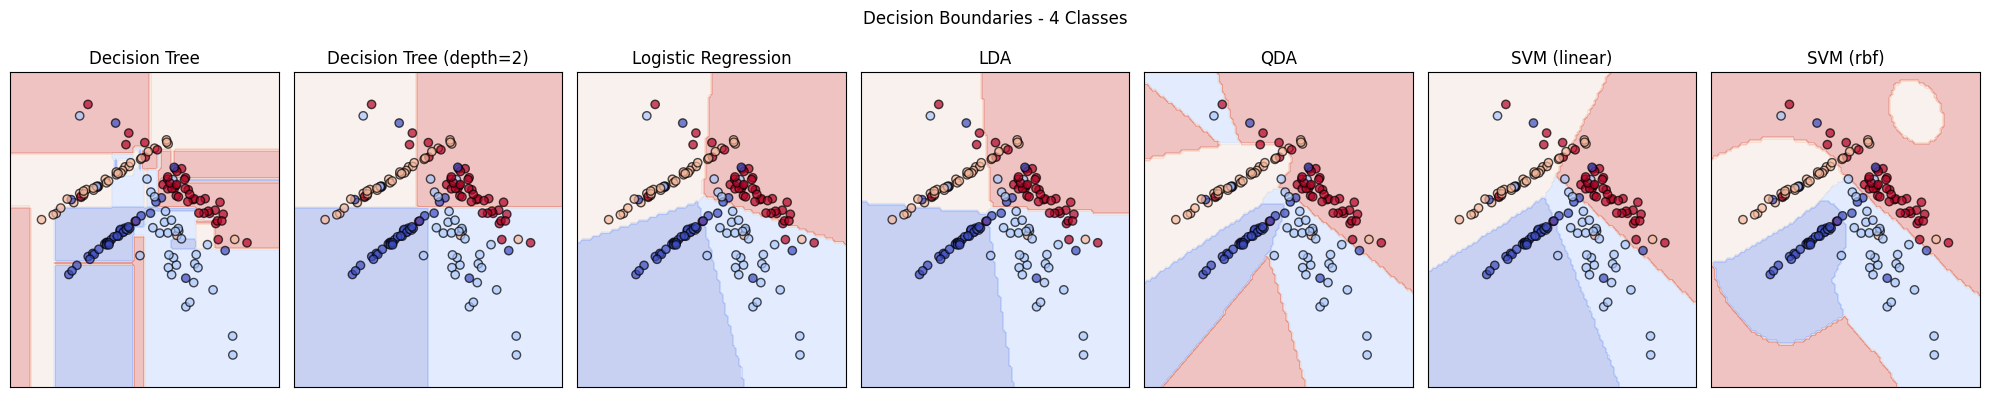

⚠️ Skipping ROC Curve (Multiclass detected) for 4 Classes


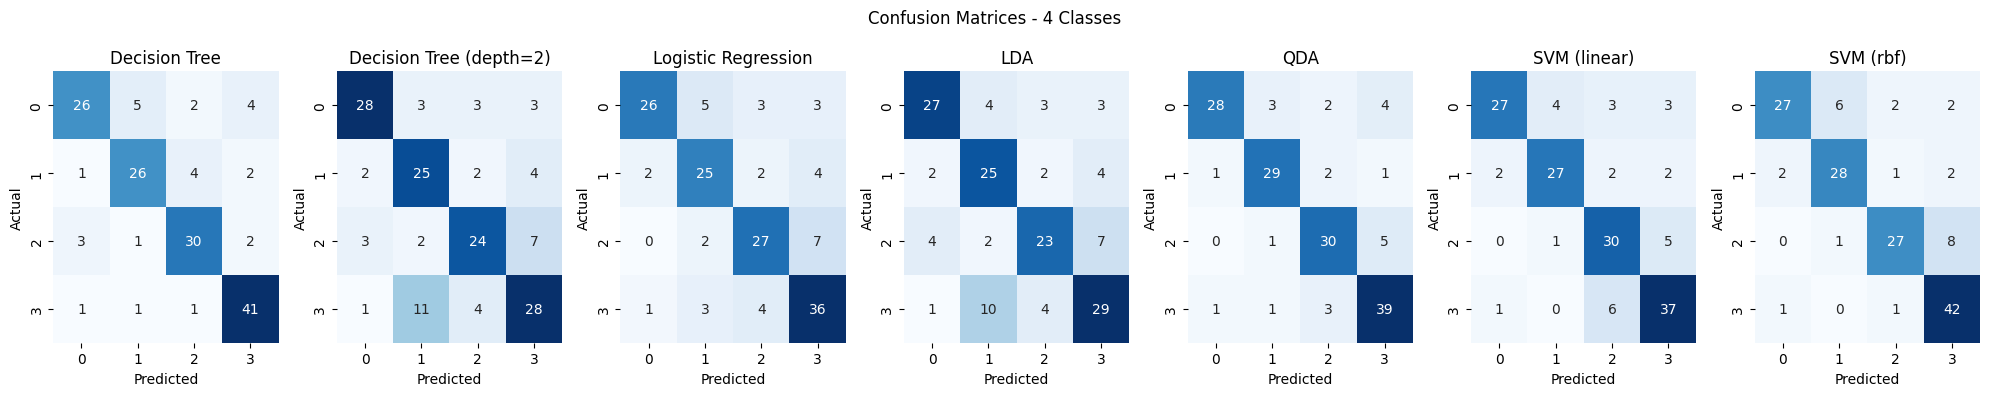

In [ ]:
evaluate_dataset("4 Classes")   


 Conclusões Principais:

- O aumento do número de classes reduz a exatidão da maioria dos modelos, pois o problema torna-se mais difícil.
- Modelos não lineares (QDA, SVM RBF) são mais estáveis ao lidar com múltiplas classes.
- Modelos lineares (Regressão Logística, LDA) começam a perder eficiência a partir de 3 classes.
- Árvores de decisão com profundidade limitada podem ajudar a reduzir overfitting, dependendo do número de classes.

# Balance Problem


📊 Evaluating Dataset: Balanced (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.81 ± 0.02
   ↪️ CV Precision: 0.80 ± 0.02
   ↪️ CV Recall: 0.80 ± 0.02
   ↪️ CV F1-score: 0.80 ± 0.03
Processing time was 0.20000004768371582 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.77 ± 0.03
   ↪️ CV Precision: 0.78 ± 0.03
   ↪️ CV Recall: 0.77 ± 0.03
   ↪️ CV F1-score: 0.77 ± 0.03
Processing time was 0.1399998664855957 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.77 ± 0.03
   ↪️ CV Precision: 0.77 ± 0.03
   ↪️ CV Recall: 0.77 ± 0.03
   ↪️ CV F1-score: 0.77 ± 0.03
Processing time was 0.21000003814697266 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.77 ± 0.04
   ↪️ CV Precision: 0.78 ± 0.03
   ↪️ CV Recall: 0.77 ± 0.04
   ↪️ CV F1-score: 0.77 ± 0.04
Processing time was 0.15000009536743164 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.74 ± 0.05
   ↪️ CV Precision: 0.76 ± 0.04
   ↪️ CV Recall: 0.74 ± 0.05
   ↪️ CV F1-score: 0.74 ± 0.05
Processing time was 0.11999988555908203 segundos
🔹

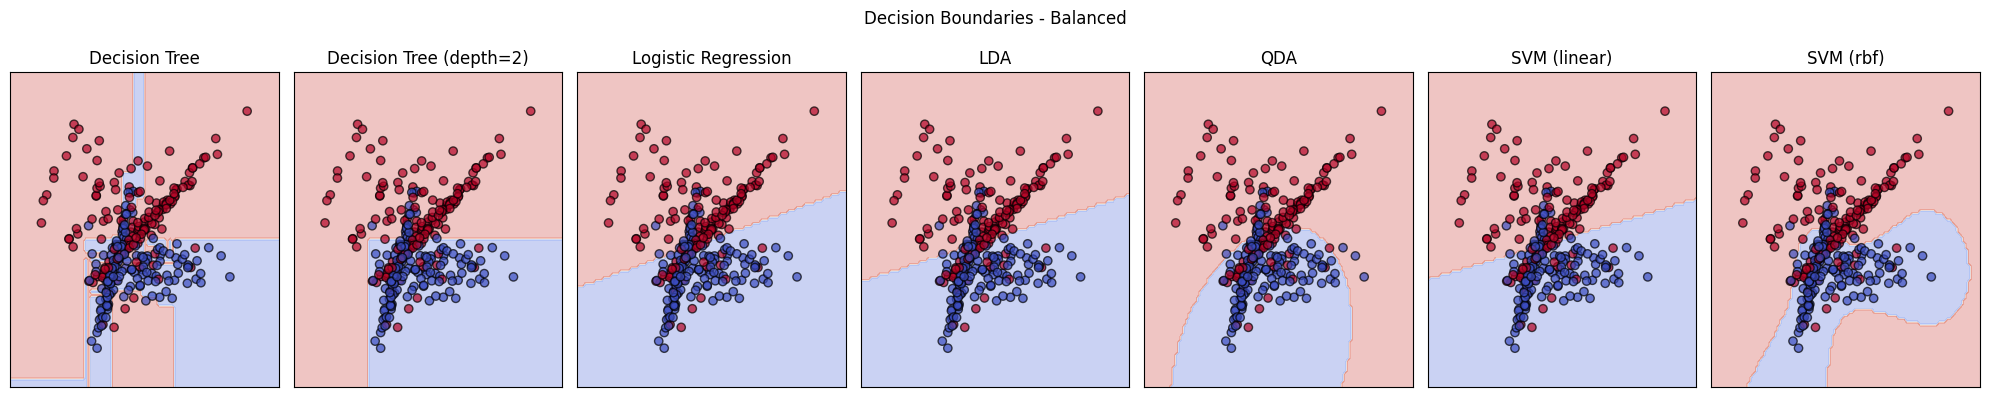

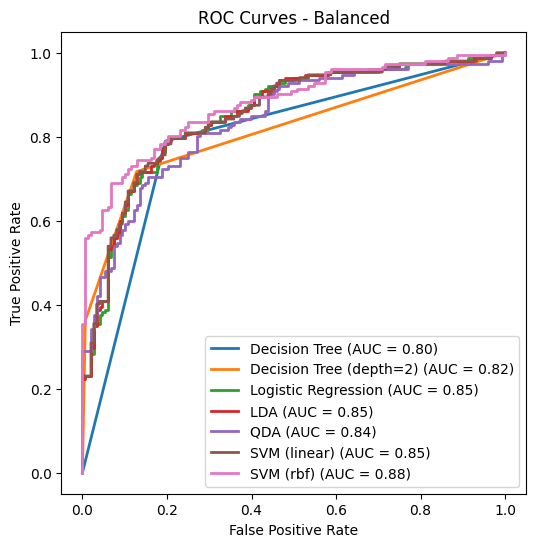

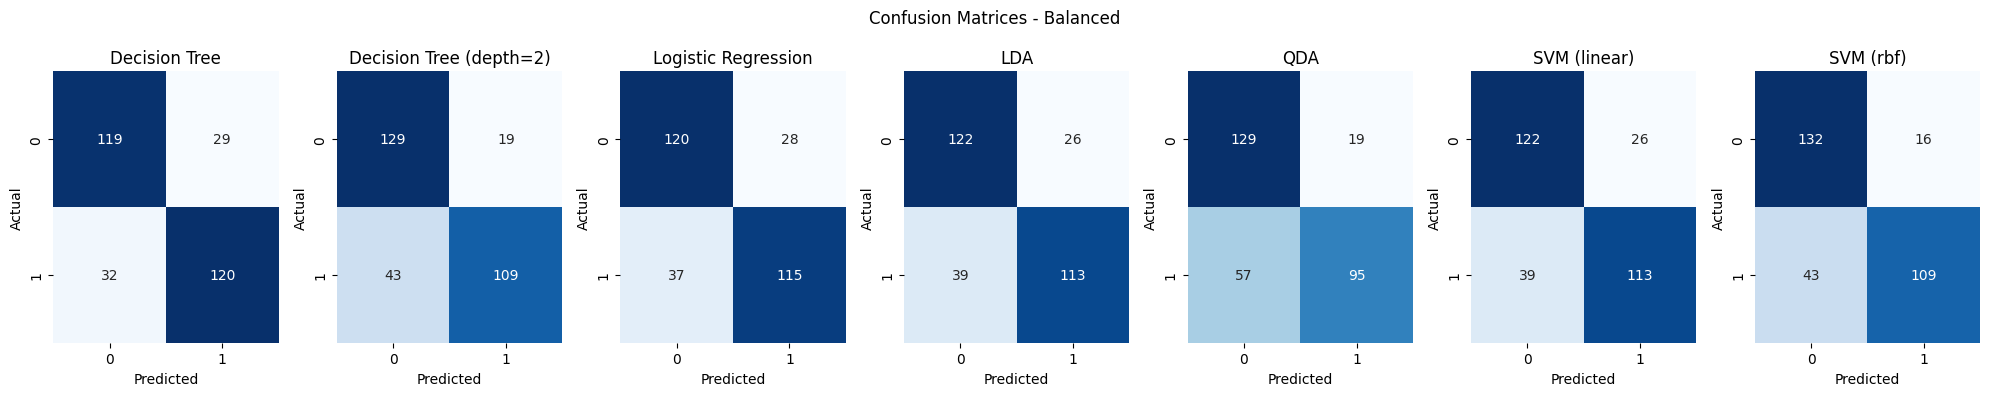

In [ ]:
evaluate_dataset("Balanced")   


📊 Evaluating Dataset: Imbalanced (70-30) (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.86 ± 0.03
   ↪️ CV Precision: 0.87 ± 0.04
   ↪️ CV Recall: 0.86 ± 0.03
   ↪️ CV F1-score: 0.86 ± 0.03
Processing time was 0.1700000762939453 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.86 ± 0.02
   ↪️ CV Precision: 0.87 ± 0.02
   ↪️ CV Recall: 0.86 ± 0.02
   ↪️ CV F1-score: 0.85 ± 0.02
Processing time was 0.14999985694885254 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.82 ± 0.04
   ↪️ CV Precision: 0.83 ± 0.03
   ↪️ CV Recall: 0.82 ± 0.04
   ↪️ CV F1-score: 0.81 ± 0.04
Processing time was 0.19000005722045898 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.81 ± 0.05
   ↪️ CV Precision: 0.82 ± 0.05
   ↪️ CV Recall: 0.81 ± 0.05
   ↪️ CV F1-score: 0.80 ± 0.05
Processing time was 0.14999985694885254 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.88 ± 0.03
   ↪️ CV Precision: 0.89 ± 0.03
   ↪️ CV Recall: 0.88 ± 0.03
   ↪️ CV F1-score: 0.87 ± 0.03
Processing time was 0.1100001335144043 s

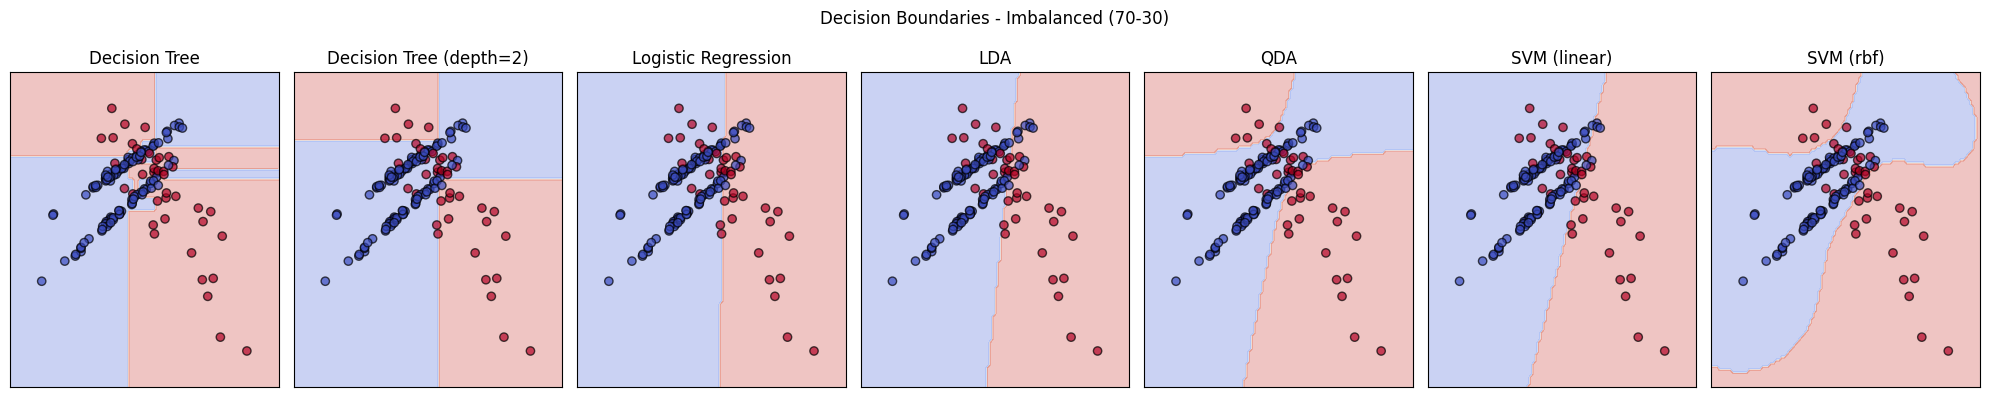

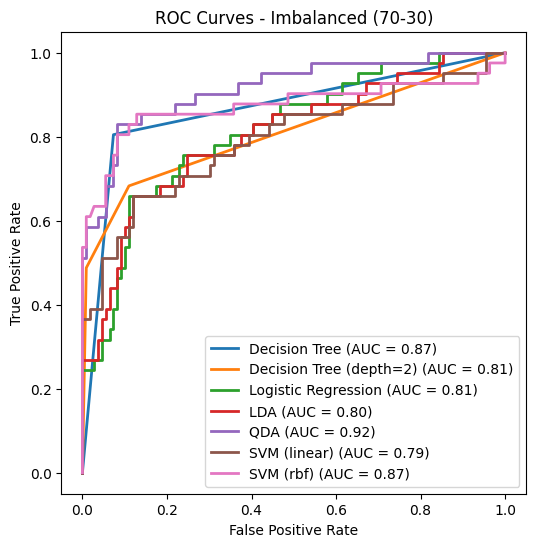

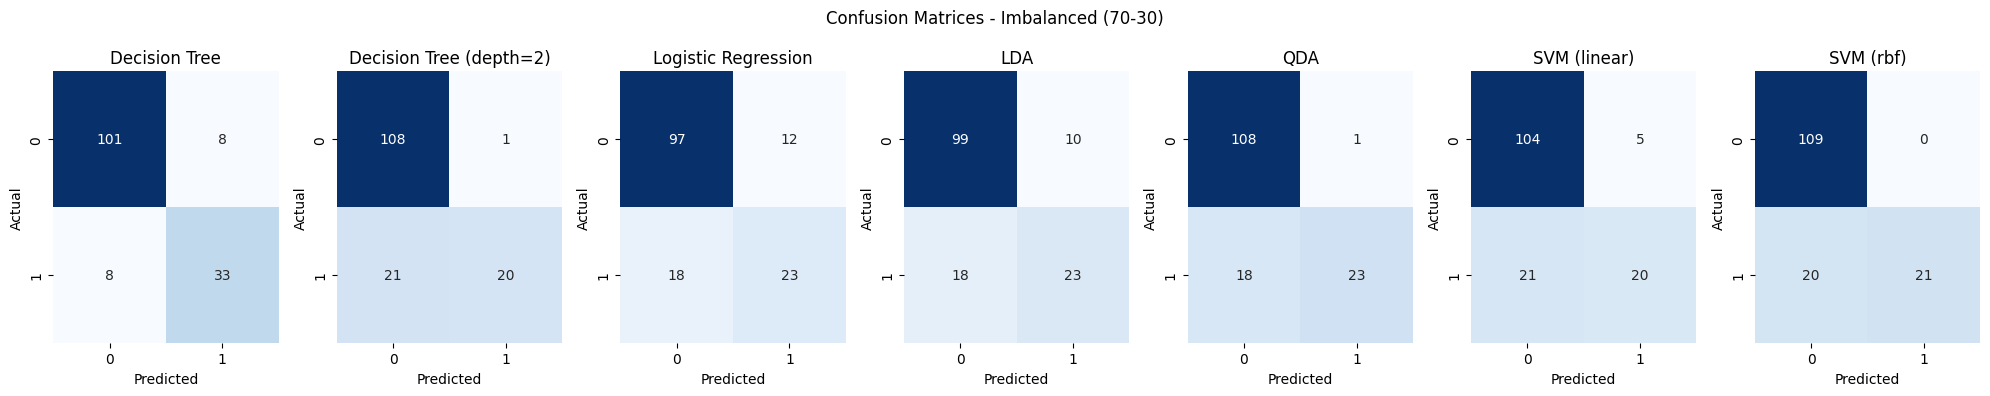

In [ ]:
evaluate_dataset("Imbalanced (70-30)") 


📊 Evaluating Dataset: Imbalanced (90-10) (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.91 ± 0.04
   ↪️ CV Precision: 0.91 ± 0.04
   ↪️ CV Recall: 0.91 ± 0.04
   ↪️ CV F1-score: 0.91 ± 0.04
Processing time was 0.14999985694885254 segundos


c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.92 ± 0.04
   ↪️ CV Precision: 0.91 ± 0.06
   ↪️ CV Recall: 0.92 ± 0.04
   ↪️ CV F1-score: 0.89 ± 0.06
Processing time was 0.13000011444091797 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.89 ± 0.02
   ↪️ CV Precision: 0.84 ± 0.06
   ↪️ CV Recall: 0.89 ± 0.02
   ↪️ CV F1-score: 0.84 ± 0.03
Processing time was 0.20000004768371582 segundos


c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 LDA:
   ↪️ CV Accuracy: 0.90 ± 0.02
   ↪️ CV Precision: 0.88 ± 0.06
   ↪️ CV Recall: 0.90 ± 0.02
   ↪️ CV F1-score: 0.86 ± 0.03
Processing time was 0.1399998664855957 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.93 ± 0.03
   ↪️ CV Precision: 0.94 ± 0.03
   ↪️ CV Recall: 0.93 ± 0.03
   ↪️ CV F1-score: 0.92 ± 0.04
Processing time was 0.12000012397766113 segundos


c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 SVM (linear):
   ↪️ CV Accuracy: 0.89 ± 0.02
   ↪️ CV Precision: 0.86 ± 0.06
   ↪️ CV Recall: 0.89 ± 0.02
   ↪️ CV F1-score: 0.85 ± 0.03
Processing time was 0.28999996185302734 segundos
🔹 SVM (rbf):
   ↪️ CV Accuracy: 0.94 ± 0.03
   ↪️ CV Precision: 0.94 ± 0.03
   ↪️ CV Recall: 0.94 ± 0.03
   ↪️ CV F1-score: 0.92 ± 0.04
Processing time was 0.38000011444091797 segundos


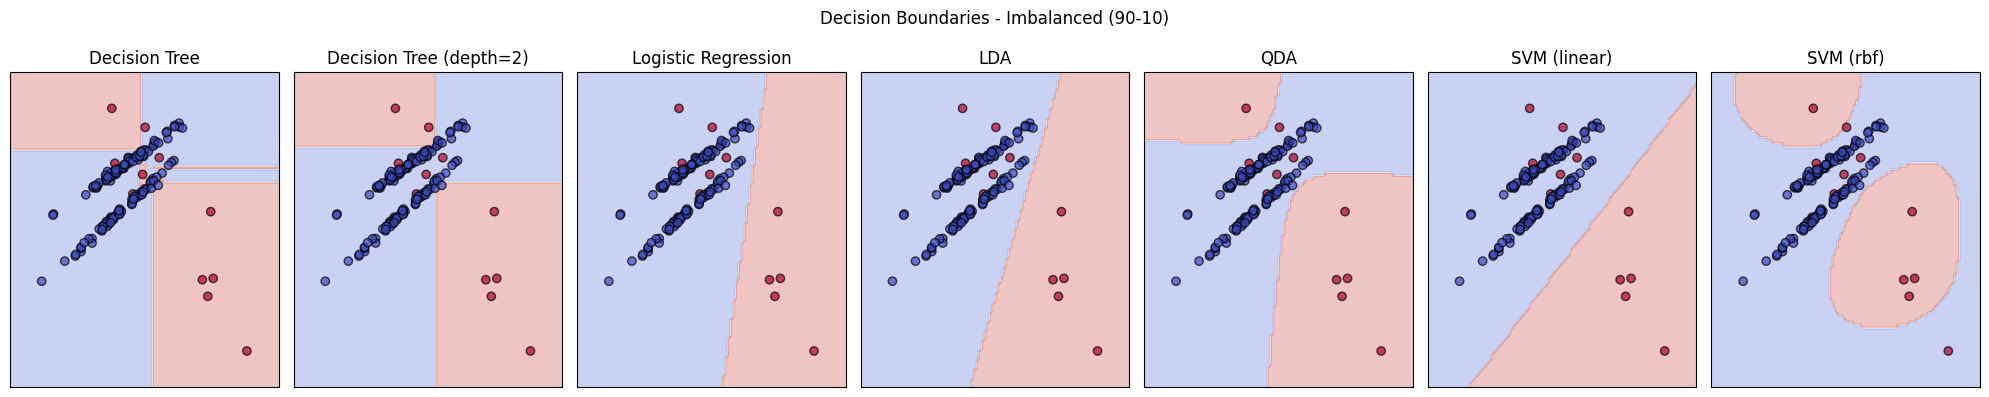

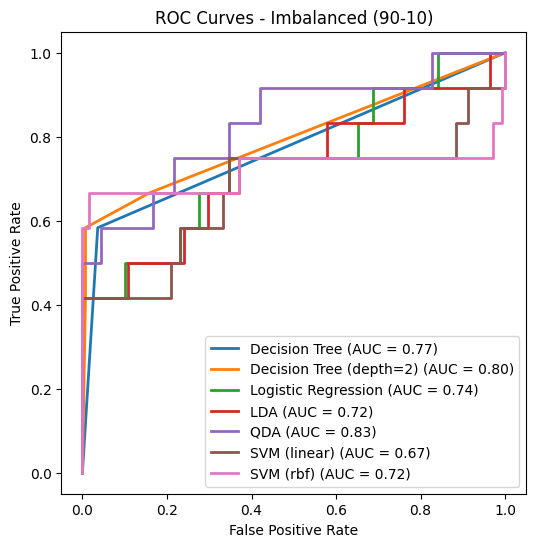

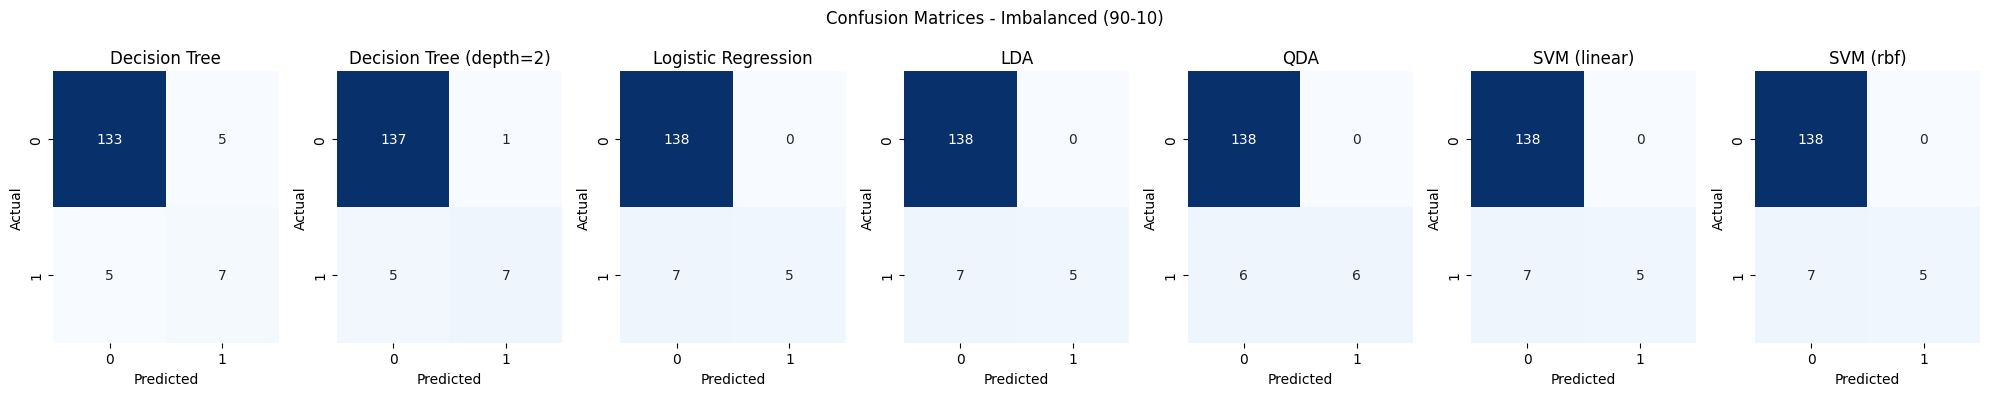

In [ ]:
evaluate_dataset("Imbalanced (90-10)") 

Robustez de Modelos ao Desbalanceamento:
Modelos como QDA e SVM (RBF) demonstraram ser mais robustos ao desbalanceamento, mantendo desempenho estável e AUC-ROC apenas ligeiramente afetado. O QDA, em particular, apresentou uma diminuição mínima no AUC-ROC de 0,84 para 0,83, indicando que o modelo tem uma boa capacidade de lidar com datasets desbalanceados, provavelmente devido à sua flexibilidade na modelagem das distribuições de classe.
Árvore de Decisão também teve um desempenho favorável com o aumento do desbalanceamento, especialmente quando utilizada com profundidades menores, o que pode indicar que a estrutura hierárquica da árvore ajuda a identificar a classe minoritária mesmo em contextos desbalanceados.

Dificuldades em Modelos de Separação Linear:
Modelos como Regressão Logística e SVM Linear sofreram uma queda no F1-score, o que se reflete em dificuldades em lidar com datasets desbalanceados. Isso é esperado, pois esses modelos dependem de separações lineares que podem não ser eficazes quando as classes estão desbalanceadas. Esses modelos podem ter dificuldades significativas em identificar corretamente a classe minoritária, o que é evidenciado pela baixa previsão dessa classe nas matrizes de confusão.

Classe Minoritária Desprezada em Matrizes de Confusão:
Uma análise detalhada das matrizes de confusão mostrou que, em datasets desbalanceados, a classe minoritária foi largamente negligenciada por diversos modelos, com muitos falsos negativos e poucos acertos. Esse fenômeno é um indicativo de que os modelos estão tendo dificuldades em capturar corretamente a classe minoritária, resultando em um desempenho prejudicado, especialmente em cenários onde a precisão da classe minoritária é crucial.

AUC-ROC e Impacto no Desbalanceamento:
A métrica AUC-ROC foi essencial para avaliar o desempenho dos modelos em cenários desbalanceados. Enquanto o QDA manteve um desempenho quase constante, outros modelos sofreram uma queda mais acentuada no AUC-ROC, refletindo a dificuldade de alguns algoritmos em lidar com o desbalanceamento. Isso destaca a importância de considerar AUC-ROC e PR AUC em vez de apenas métricas como precisão ou F1-score, especialmente em datasets desbalanceados.


# Distribution of points (shape of point clouds)


📊 Evaluating Dataset: Gaussian (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.77 ± 0.07
   ↪️ CV Precision: 0.76 ± 0.07
   ↪️ CV Recall: 0.77 ± 0.06
   ↪️ CV F1-score: 0.76 ± 0.08
Processing time was 0.16000008583068848 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.80 ± 0.02
   ↪️ CV Precision: 0.81 ± 0.02
   ↪️ CV Recall: 0.80 ± 0.02
   ↪️ CV F1-score: 0.80 ± 0.02
Processing time was 0.12999987602233887 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.82 ± 0.03
   ↪️ CV Precision: 0.82 ± 0.03
   ↪️ CV Recall: 0.82 ± 0.03
   ↪️ CV F1-score: 0.82 ± 0.03
Processing time was 0.25999999046325684 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.82 ± 0.03
   ↪️ CV Precision: 0.82 ± 0.04
   ↪️ CV Recall: 0.82 ± 0.03
   ↪️ CV F1-score: 0.82 ± 0.03
Processing time was 0.1400001049041748 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.82 ± 0.04
   ↪️ CV Precision: 0.83 ± 0.04
   ↪️ CV Recall: 0.82 ± 0.04
   ↪️ CV F1-score: 0.82 ± 0.04
Processing time was 0.1399998664855957 segundos
🔹 

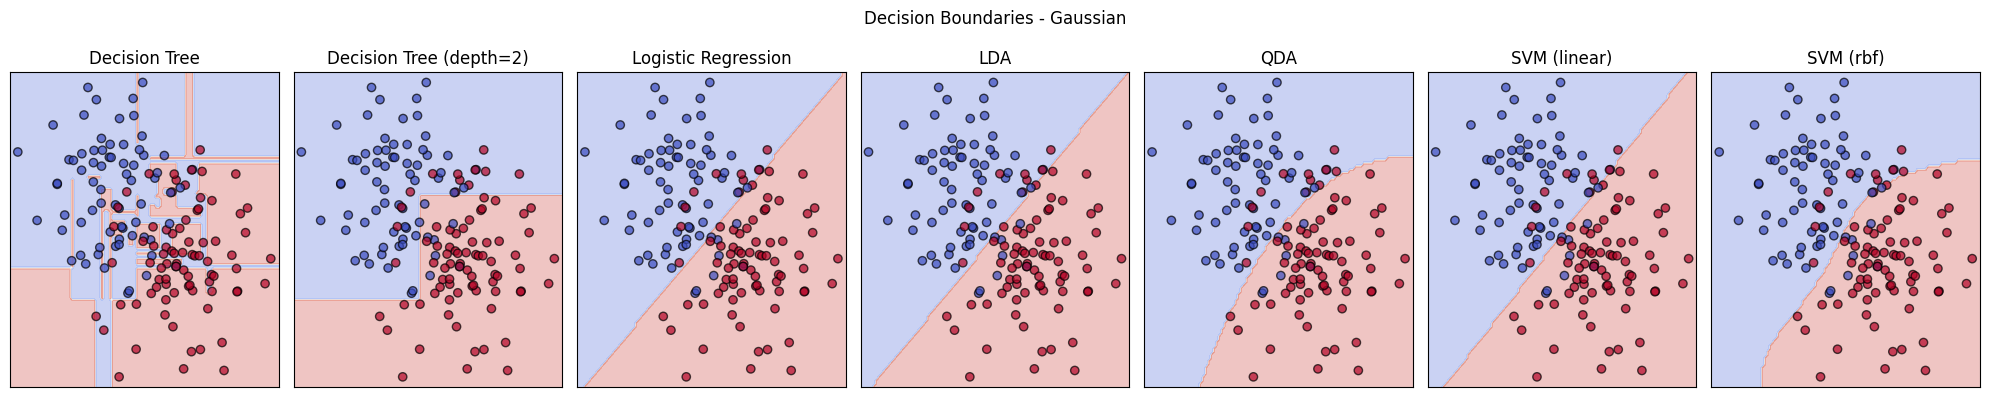

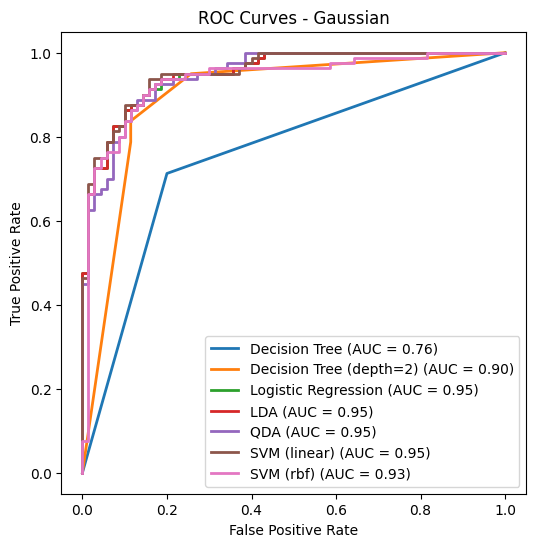

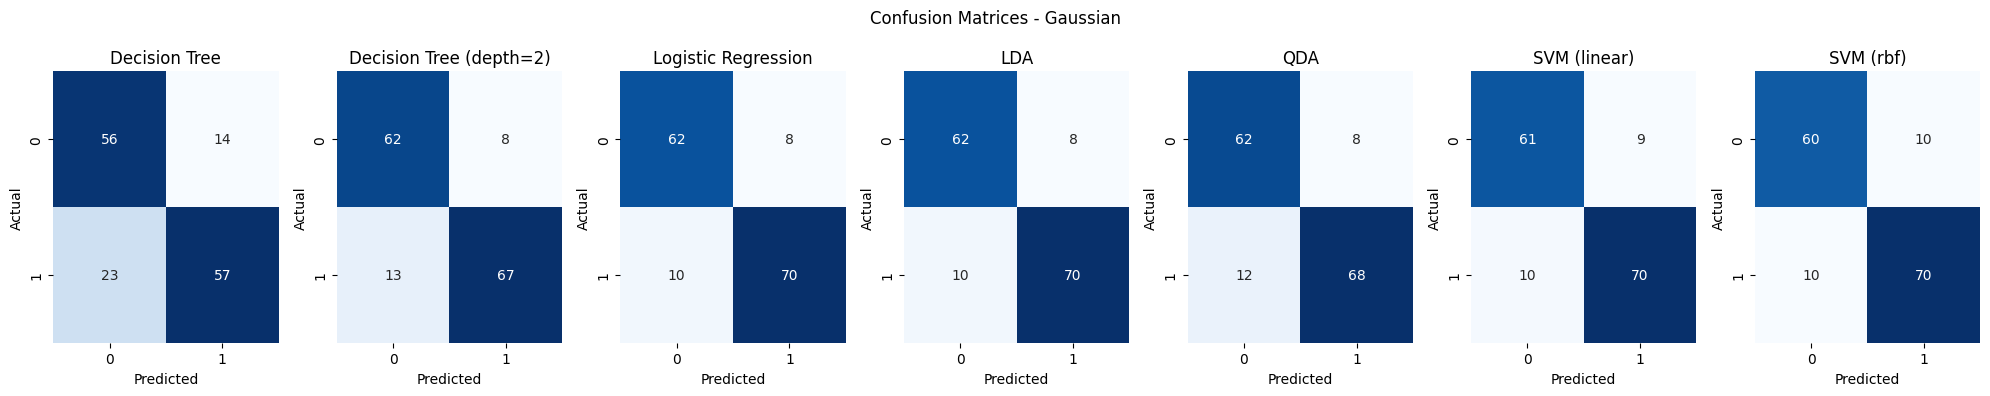

In [ ]:
evaluate_dataset("Gaussian") 


📊 Evaluating Dataset: Circular (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.94 ± 0.05
   ↪️ CV Precision: 0.94 ± 0.04
   ↪️ CV Recall: 0.94 ± 0.05
   ↪️ CV F1-score: 0.93 ± 0.05
Processing time was 0.1700000762939453 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.72 ± 0.03
   ↪️ CV Precision: 0.77 ± 0.04
   ↪️ CV Recall: 0.72 ± 0.03
   ↪️ CV F1-score: 0.70 ± 0.04
Processing time was 0.1399998664855957 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.47 ± 0.02
   ↪️ CV Precision: 0.47 ± 0.02
   ↪️ CV Recall: 0.47 ± 0.02
   ↪️ CV F1-score: 0.46 ± 0.01
Processing time was 0.18000006675720215 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.47 ± 0.02
   ↪️ CV Precision: 0.47 ± 0.02
   ↪️ CV Recall: 0.47 ± 0.02
   ↪️ CV F1-score: 0.46 ± 0.01
Processing time was 0.11999988555908203 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.97 ± 0.02
   ↪️ CV Precision: 0.98 ± 0.02
   ↪️ CV Recall: 0.97 ± 0.02
   ↪️ CV F1-score: 0.97 ± 0.02
Processing time was 0.13000011444091797 segundos
🔹 

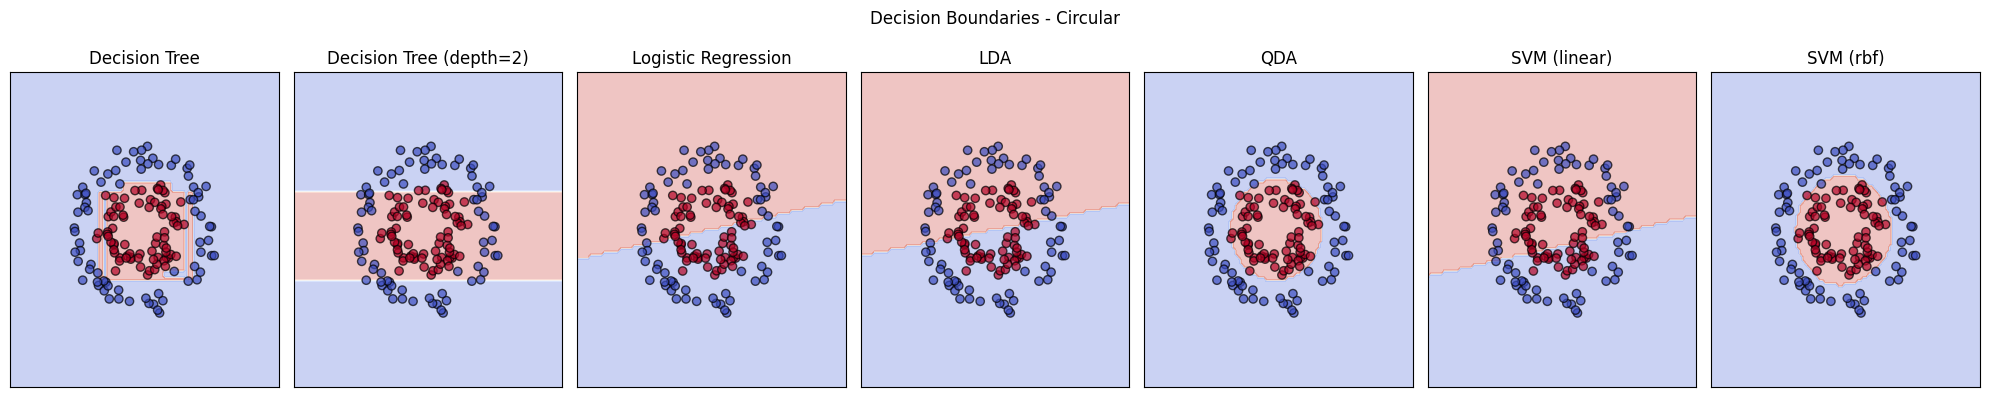

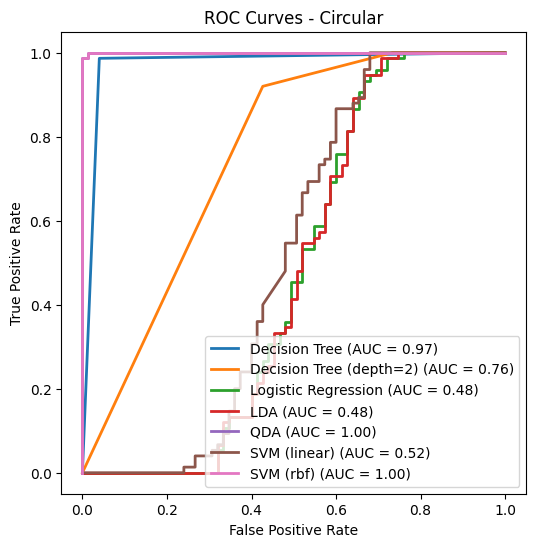

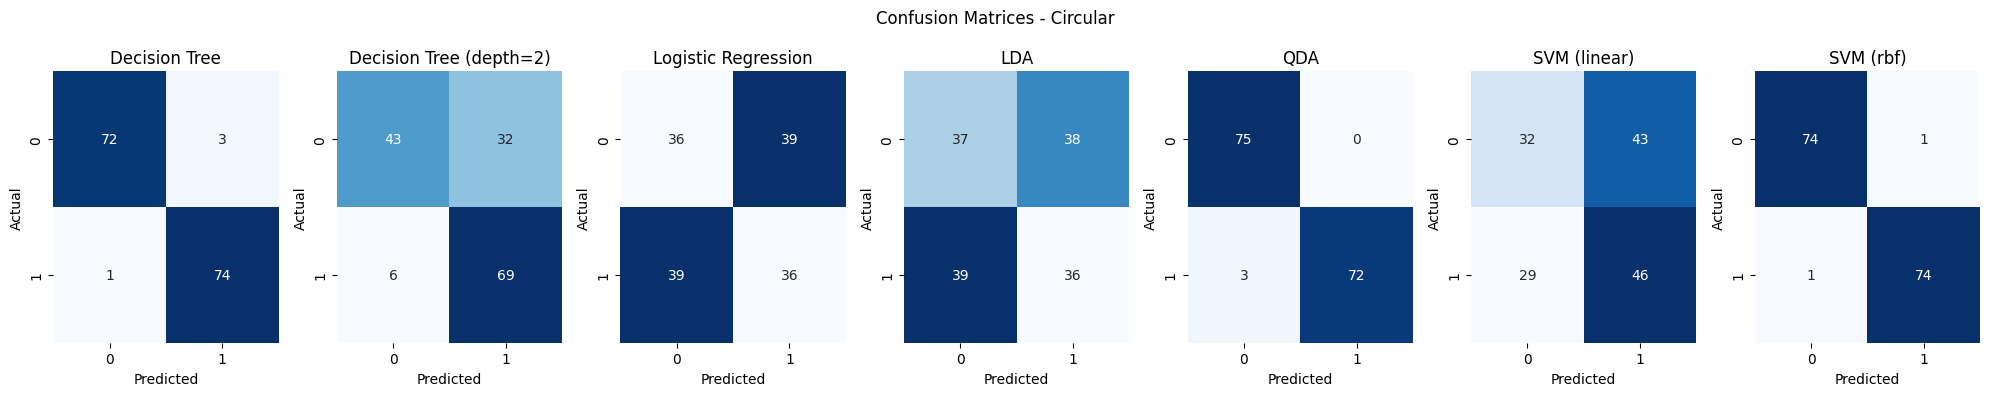

In [ ]:
evaluate_dataset("Circular") 


📊 Evaluating Dataset: Moons (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.96 ± 0.02
   ↪️ CV Precision: 0.97 ± 0.01
   ↪️ CV Recall: 0.96 ± 0.02
   ↪️ CV F1-score: 0.96 ± 0.02
Processing time was 0.16000008583068848 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.91 ± 0.03
   ↪️ CV Precision: 0.92 ± 0.03
   ↪️ CV Recall: 0.91 ± 0.03
   ↪️ CV F1-score: 0.91 ± 0.03
Processing time was 0.14999985694885254 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.85 ± 0.04
   ↪️ CV Precision: 0.85 ± 0.04
   ↪️ CV Recall: 0.85 ± 0.04
   ↪️ CV F1-score: 0.85 ± 0.04
Processing time was 0.21000003814697266 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.85 ± 0.03
   ↪️ CV Precision: 0.85 ± 0.03
   ↪️ CV Recall: 0.85 ± 0.03
   ↪️ CV F1-score: 0.85 ± 0.03
Processing time was 0.13000011444091797 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.85 ± 0.04
   ↪️ CV Precision: 0.85 ± 0.04
   ↪️ CV Recall: 0.85 ± 0.04
   ↪️ CV F1-score: 0.85 ± 0.04
Processing time was 0.11999988555908203 segundos
🔹 S

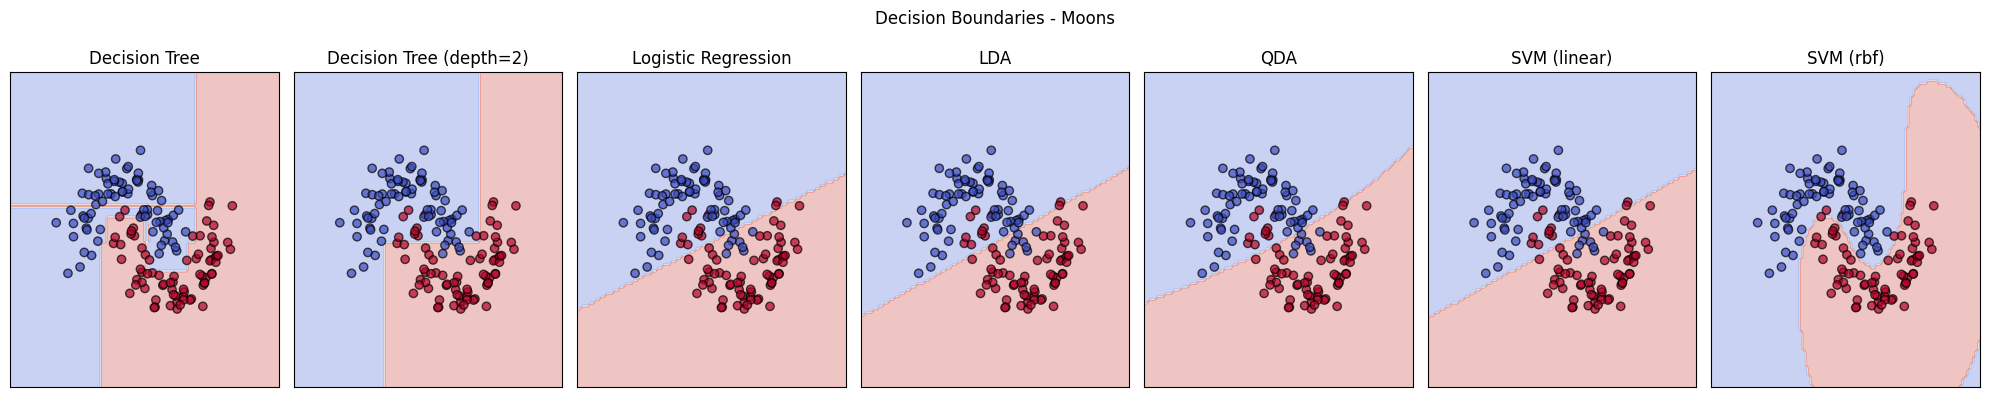

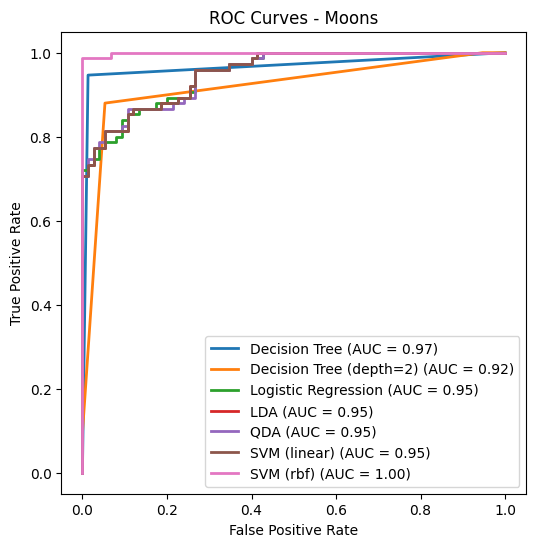

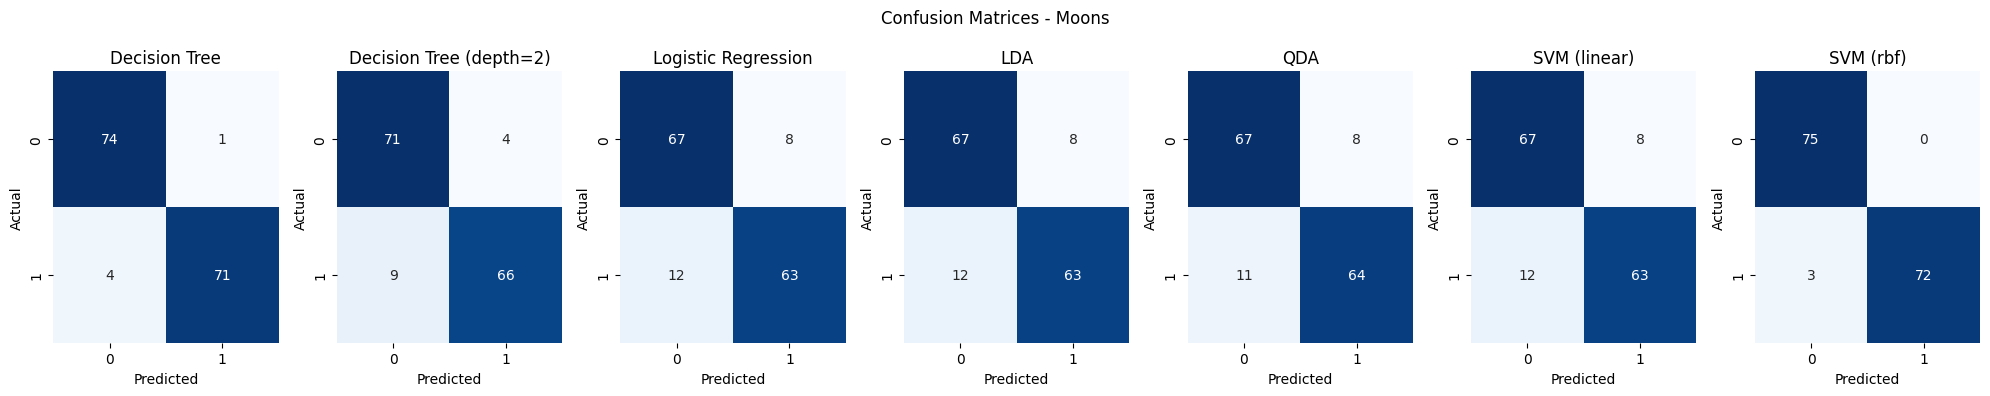

In [ ]:
evaluate_dataset("Moons") 

Fronteira linear Vs Não Linear 


📊 Evaluating Dataset: Linear Border (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.97 ± 0.02
   ↪️ CV Precision: 0.97 ± 0.02
   ↪️ CV Recall: 0.97 ± 0.02
   ↪️ CV F1-score: 0.97 ± 0.02
Processing time was 0.16 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.98 ± 0.03
   ↪️ CV Precision: 0.98 ± 0.02
   ↪️ CV Recall: 0.98 ± 0.03
   ↪️ CV F1-score: 0.98 ± 0.03
Processing time was 0.1 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.97 ± 0.02
   ↪️ CV Precision: 0.98 ± 0.02
   ↪️ CV Recall: 0.97 ± 0.02
   ↪️ CV F1-score: 0.97 ± 0.02
Processing time was 0.22 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.97 ± 0.02
   ↪️ CV Precision: 0.98 ± 0.02
   ↪️ CV Recall: 0.97 ± 0.02
   ↪️ CV F1-score: 0.97 ± 0.02
Processing time was 0.08 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.97 ± 0.02
   ↪️ CV Precision: 0.98 ± 0.02
   ↪️ CV Recall: 0.97 ± 0.02
   ↪️ CV F1-score: 0.97 ± 0.02
Processing time was 0.07 segundos
🔹 SVM (linear):
   ↪️ CV Accuracy: 0.98 ± 0.02
   ↪️ CV Precision: 0.98

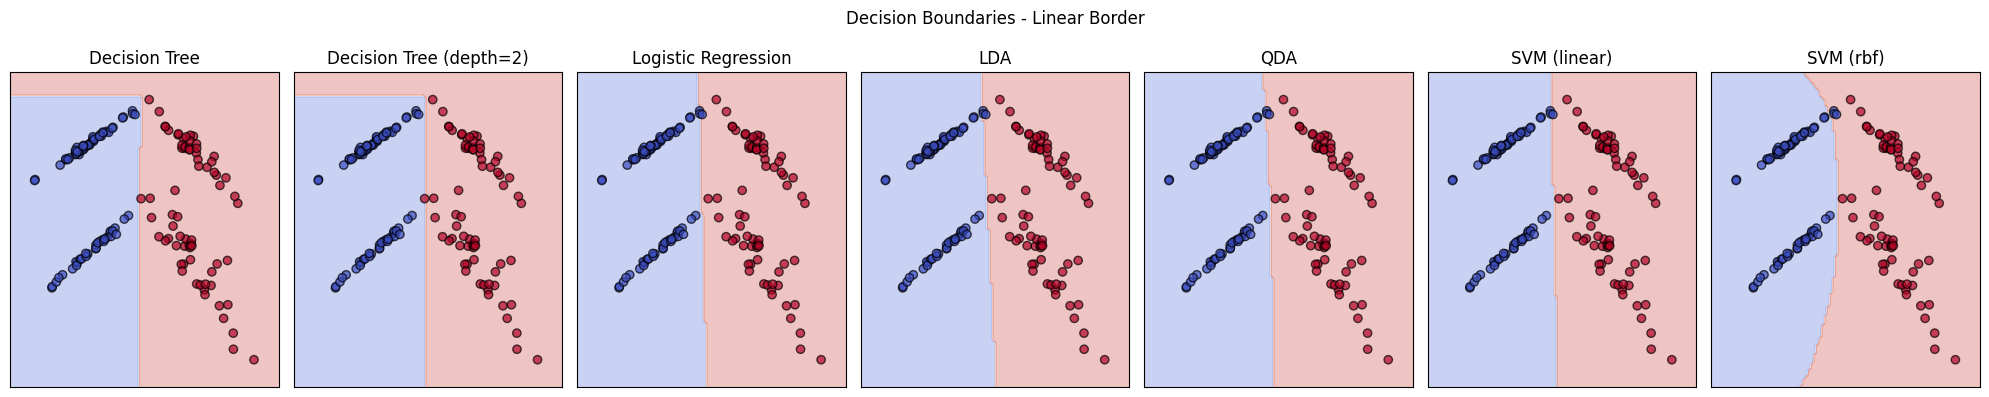

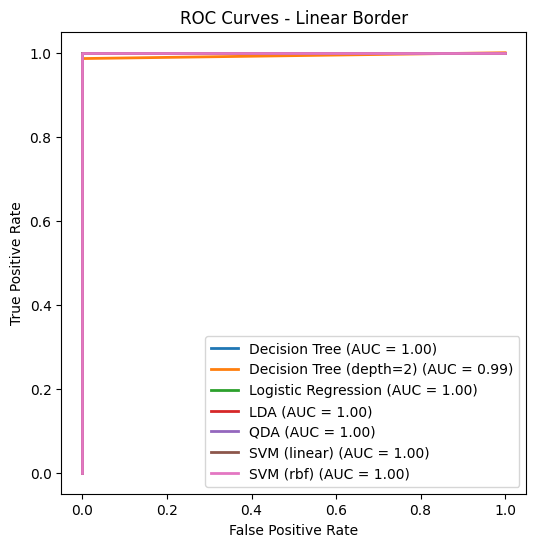

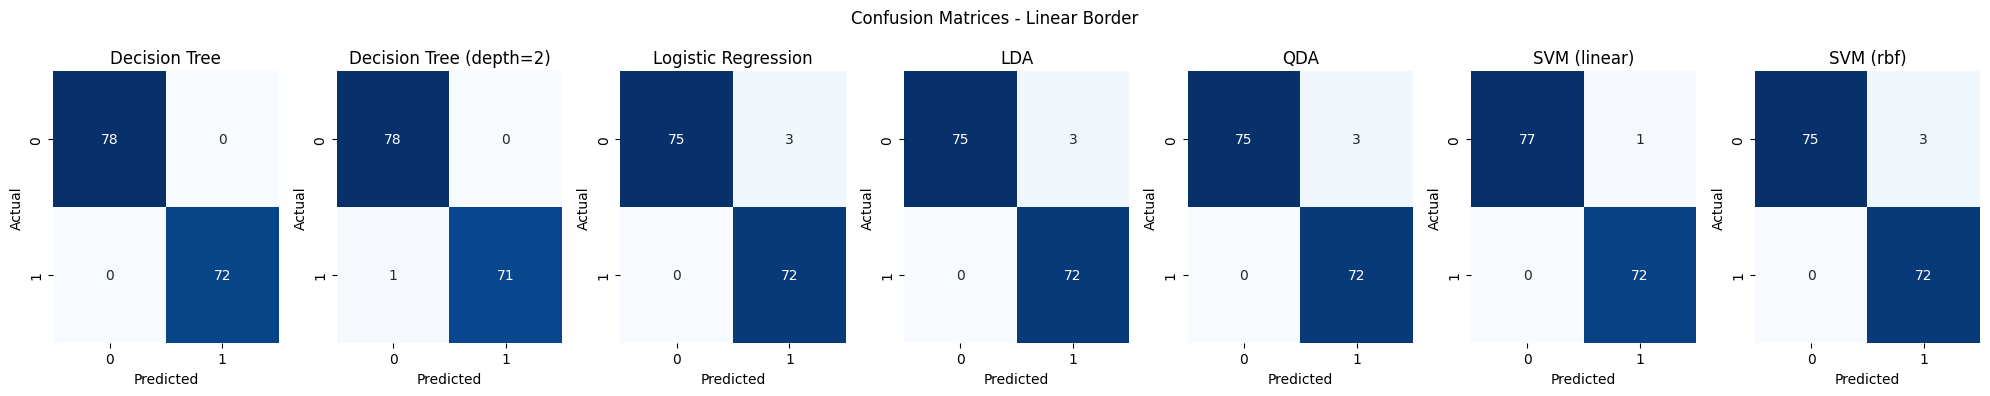


📊 Evaluating Dataset: Non-Linear Border (Cross-Validation: 5-fold)
🔹 Decision Tree:
   ↪️ CV Accuracy: 0.96 ± 0.02
   ↪️ CV Precision: 0.95 ± 0.02
   ↪️ CV Recall: 0.96 ± 0.02
   ↪️ CV F1-score: 0.95 ± 0.02
Processing time was 0.1 segundos
🔹 Decision Tree (depth=2):
   ↪️ CV Accuracy: 0.73 ± 0.03
   ↪️ CV Precision: 0.81 ± 0.02
   ↪️ CV Recall: 0.73 ± 0.03
   ↪️ CV F1-score: 0.71 ± 0.04
Processing time was 0.08 segundos
🔹 Logistic Regression:
   ↪️ CV Accuracy: 0.47 ± 0.05
   ↪️ CV Precision: 0.44 ± 0.14
   ↪️ CV Recall: 0.47 ± 0.05
   ↪️ CV F1-score: 0.43 ± 0.11
Processing time was 0.13 segundos
🔹 LDA:
   ↪️ CV Accuracy: 0.47 ± 0.05
   ↪️ CV Precision: 0.44 ± 0.14
   ↪️ CV Recall: 0.47 ± 0.05
   ↪️ CV F1-score: 0.44 ± 0.10
Processing time was 0.08 segundos
🔹 QDA:
   ↪️ CV Accuracy: 0.96 ± 0.02
   ↪️ CV Precision: 0.96 ± 0.02
   ↪️ CV Recall: 0.96 ± 0.02
   ↪️ CV F1-score: 0.96 ± 0.02
Processing time was 0.06 segundos


c:\Users\berna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 SVM (linear):
   ↪️ CV Accuracy: 0.55 ± 0.08
   ↪️ CV Precision: 0.55 ± 0.20
   ↪️ CV Recall: 0.55 ± 0.08
   ↪️ CV F1-score: 0.49 ± 0.13
Processing time was 0.39 segundos
🔹 SVM (rbf):
   ↪️ CV Accuracy: 0.97 ± 0.01
   ↪️ CV Precision: 0.97 ± 0.01
   ↪️ CV Recall: 0.97 ± 0.01
   ↪️ CV F1-score: 0.97 ± 0.01
Processing time was 0.23 segundos


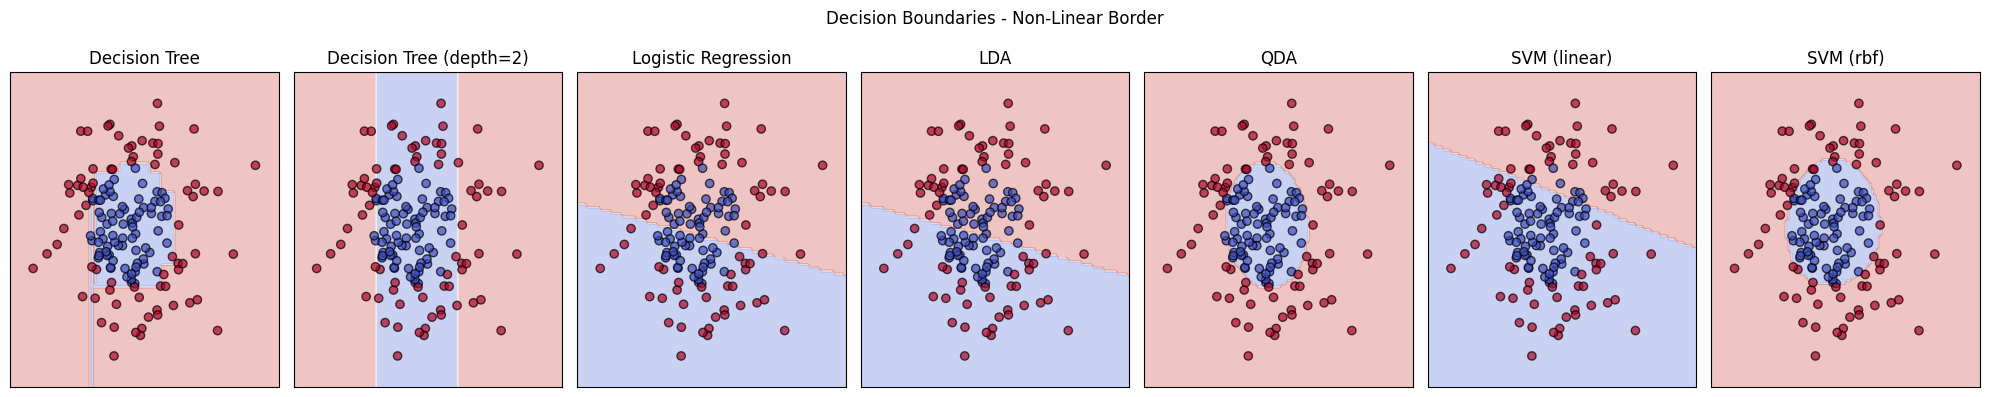

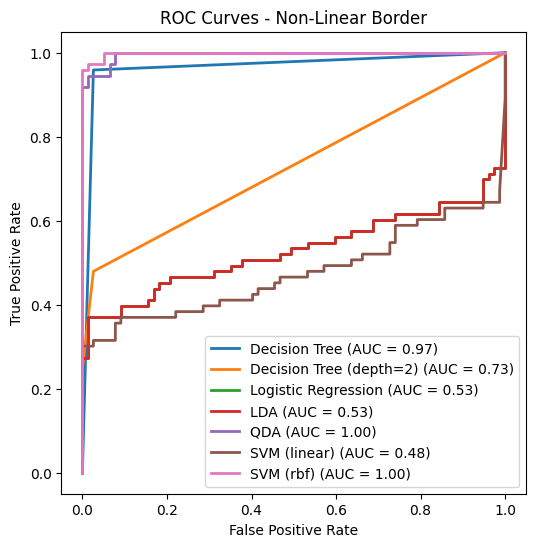

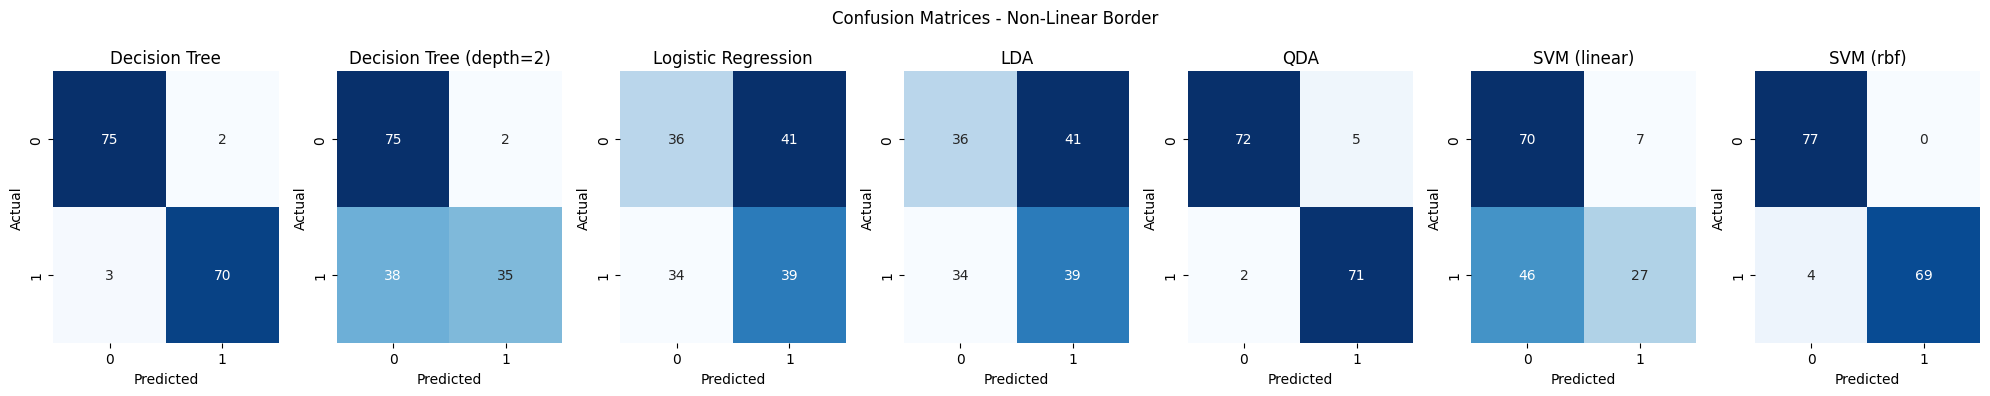

In [99]:
evaluate_dataset("Linear Border")
evaluate_dataset("Non-Linear Border")

Conclusões:
- Ao analisar um dataset com fronteiras lineares todos os algoritmos em análise tiveram facilidade em obter valores elevados em todas as métricas. Ao alterar a fronteira em análise para uma fronteira não linear, os algoritmos com uma análise linear (SVM linear, Logistic Regression e LDA) tiveram o seu desempenho prejudicado de forma mais agressiva. As decision trees mantiveram um desempenho superior aos dos algoritmos previamente mencionados, no entanto a decision tree com max depth=2 permitiu observar que datasets com fronteiras não lineares exigem que a decison tree tenha pelo menos uma max depth de 4 nós.Os algoritmos SVM rbf e QDA que quase não tiveram uma diminuição de desempenho uma vez que permitem a criação de limites de decisão não lineares.
